In [1]:
import os
import random

import torch
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

from tqdm import tqdm   # show loops progress

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 4070 Ti SUPER


**SEED**

In [4]:
SEED:int = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

**LOAD TRAIN DATA**

In [5]:
# Dataset personalizado para DRIVE
class Dataset(Dataset):
    def __init__(self, image_dir, ground_truth, transform=None, transform_img=None):
        self.image_dir = image_dir
        self.ground_truth_dir = ground_truth
        self.image_filenames = os.listdir(image_dir)  
        self.mask_filenames = os.listdir(ground_truth)   
        self.transform = transform
        self.transform_img = transform_img

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        ground_truth = Image.open(ground_truth_path).convert('L')  # gt to grayscale
        
        # image to tensor (needed to concatenate and more)
        image = transforms.ToTensor()(image)
        ground_truth = transforms.ToTensor()(ground_truth)
        
        if self.transform:        # exactly same transformations to image and gt
            # Concatenate along channel dimension.
            # Here, dim=0 is the channel dimension (not the batch dim) (here we have [C, H, W])
            image_and_gt = torch.cat([image, ground_truth], dim=0) 
            
            # Transform together
            transformed = self.transform(image_and_gt)

            # Slice the tensors out
            image = transformed[:3, :, :]    
            ground_truth = (transformed[3:, :, :] > 0.5).float()       # binarize !!!
        
        
        if self.transform_img:       # transformations only for images
            image = self.transform_img(image)
            

        return image, ground_truth, self.image_filenames[idx]

In [6]:
# Routes for training data
image_dir = './data/CHASE/training/images'
ground_truth_dir = './data/CHASE/training/2nd_manual'

''' # Just compute the mean and std
from torchvision import datasets
# calculate mean and std
dataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

NORM_MEAN = 0.
NORM_STD = 0.
for images, _, _ in dataloader:
    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)
    NORM_STD += images.std([0, 2, 3])    # channels std

NORM_MEAN /= len(dataloader)
NORM_STD /= len(dataloader)

print(f"Mean: {NORM_MEAN}")
print(f"Std: {NORM_STD}")'''

' # Just compute the mean and std\nfrom torchvision import datasets\n# calculate mean and std\ndataset = Dataset(image_dir, ground_truth_dir, transform=transforms.ToTensor())\ndataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)\n\nNORM_MEAN = 0.\nNORM_STD = 0.\nfor images, _, _ in dataloader:\n    NORM_MEAN += images.mean([0, 2, 3])  # channels means (R, G, B)\n    NORM_STD += images.std([0, 2, 3])    # channels std\n\nNORM_MEAN /= len(dataloader)\nNORM_STD /= len(dataloader)\n\nprint(f"Mean: {NORM_MEAN}")\nprint(f"Std: {NORM_STD}")'

In [7]:
IMG_SIZE:int = 512
DATA_AUG_PROB:float = 0.85

from torchvision.transforms import v2

# transforms for images and its ground truth segmentations (same for both)
transform = v2.Compose([
    v2.RandomApply([
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        #v2.RandomZoomOut(fill=0, p=0.2), 
        v2.RandomAffine(degrees=(-180, 180), translate=(0.1, 0.1), scale=(0.5, 1.5)),
        #v2.RandomResizedCrop(IMG_SIZE),
        #v2.ElasticTransform(alpha=15.0),
        #v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
        
    ], p=DATA_AUG_PROB),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    
    # transforms.Grayscale(num_output_channels=1),       # we want rgb    
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])

# transform just for the image
transform_img = v2.Compose([
    v2.RandomApply([
        v2.ColorJitter(brightness=[0.6, 1.2], contrast=[0.3, 1.3], saturation=[0.5, 1.3], hue=0.015),
        v2.RandomAdjustSharpness(sharpness_factor=1.5),
        #v2.GaussianNoise(),

    ], p=DATA_AUG_PROB),
     
    #transforms.ToTensor(),             # already tensors
    #transforms.Normalize(mean=NORM_MEAN, std=NORM_STD),   # no
    
])


dataset = Dataset(image_dir, ground_truth_dir, transform=transform, transform_img=transform_img)

In [8]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)
for img, gt, _ in example_loader:
    print(img.shape)
    print(gt.shape)
    print("\n")
    break

torch.Size([8, 3, 512, 512])
torch.Size([8, 1, 512, 512])




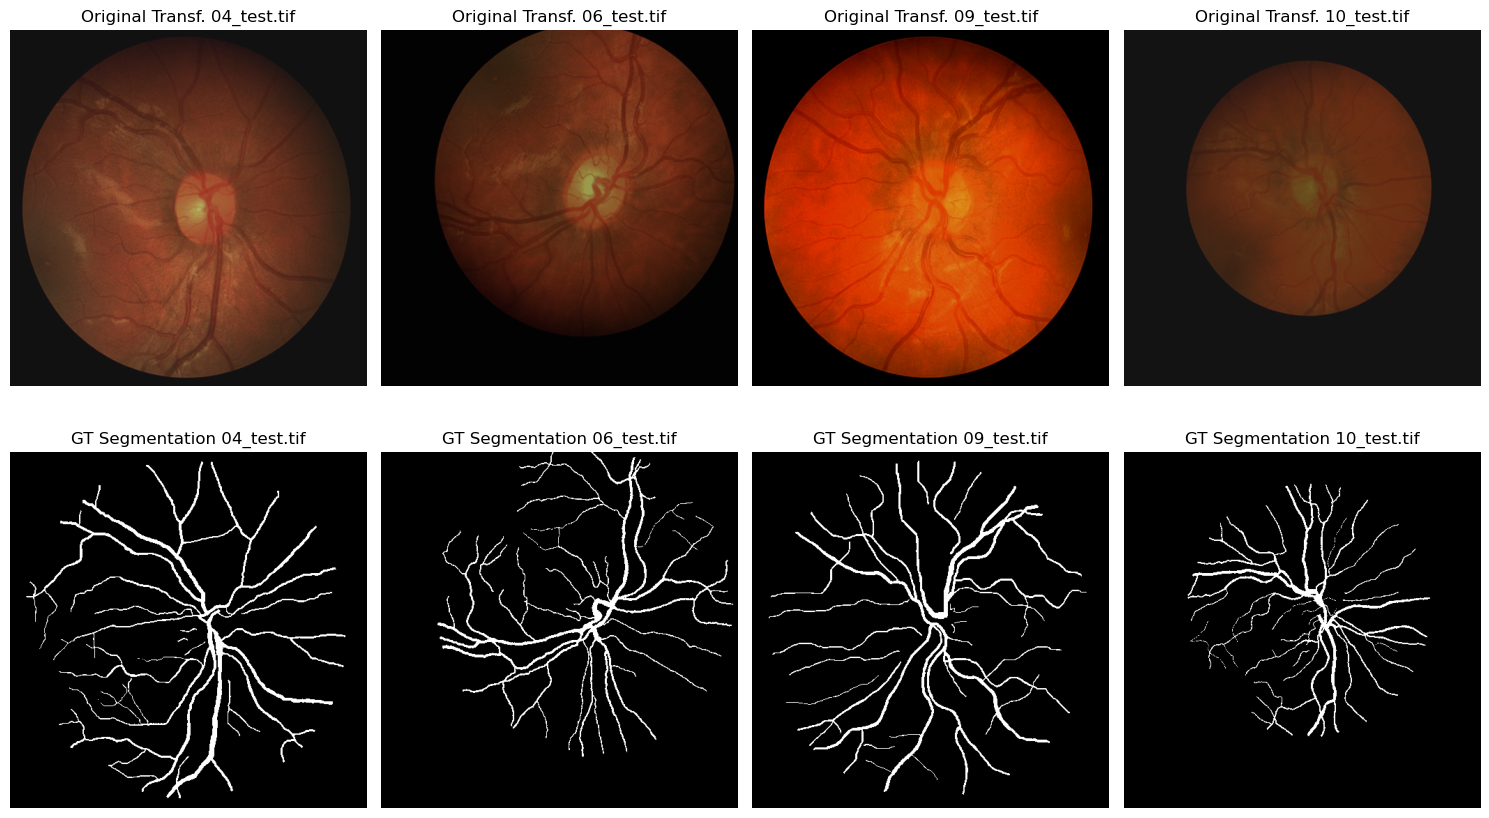

In [9]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, ground_truth, img_name = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
ground_truth = ground_truth.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
ground_truth = np.squeeze(ground_truth)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 9))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original Transf. {img_name[i]}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(ground_truth[i], cmap='gray')  # show as grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'GT Segmentation {img_name[i]}')

plt.tight_layout()
plt.show()

**DATA SPLITTING**

In [10]:
VAL_PERCENT:float = 0.2            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 4

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 16 instances
Validation set has 4 instances


In [11]:
sample_image, sample_gt, _ = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_gt.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


**CREATE MODEL**

In [12]:
# from unet import UNet
# model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)

# from vig import ViGClassifier
# NUM_PATCHES:int = 196    #196
# PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
# print(f"{PATCH_SIZE=}")
# model = ViGClassifier(in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
#                    n_classes = NUM_CHANNELS_OUT,                                  # number of classes to predict
#                    num_patches = NUM_PATCHES,                                      
#                    patch_size = PATCH_SIZE,
#                    output_size = IMG_SIZE,
#                    out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
#                    num_ViGBlocks=12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)
#                    hidden_layer=1024,
#                    num_edges=7,                                                   # number of neigbours per node
#                    head_num=2,
#                   )


from vig_unet import ViGUNet
NUM_PATCHES:int = 14*14   #196         # ONLY PERFECT SQUARES
PATCH_SIZE:int = int(IMG_SIZE//np.sqrt(NUM_PATCHES))
model = ViGUNet(n_channels = NUM_CHANNELS_IN,
                n_classes = NUM_CHANNELS_OUT,                 # number of classes to predict
                in_features = NUM_CHANNELS_IN * PATCH_SIZE * PATCH_SIZE,       # size of each input patch
                out_feature = 192,                                             # features per node/patch (tiny: 192 |small: 320 |base: 640)
                num_patches = NUM_PATCHES,
                num_ViGBlocks = 12,                                              # number of Grapher module + FFN (tiny: 12 |small: 16 |base: 16)                                      
                num_edges = 9,   #9                                              # number of neigbours per node
                head_num = 1,    #1
                patch_size = PATCH_SIZE,
                output_size = IMG_SIZE,
                )


# cuda if available, cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")
model.to(device)      # move to cuda if possible

#from torchsummary import summary
#summary(model, (NUM_CHANNELS_IN, IMG_SIZE, IMG_SIZE))

device.type='cuda'


ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

**SOME HYPERPARAMETERS, SAVE PATH, CUDA**

In [13]:
EPOCHS:int = 700

# save best model state path
SAVE_PATH = "./trained_models"
       

# LOSS FUNCTION -----------------------------------------------------
from utils.loss_functions import DiceLoss, DiceBCELoss, DiceBCELossWithTopology
#(need sigmoid at the end of network)

#loss_fn = torch.nn.BCELoss()        # binary cross-entropy loss 
#loss_fn = DiceLoss()
#loss_fn = DiceBCELoss(bce_weight=0.5)      # weight of BCE
loss_fn = DiceBCELossWithTopology(bce_weight=0.5, topology_weight=1, image_pixels=IMG_SIZE*IMG_SIZE)


# OPTIMIZER ---------------------------------------------------------
LEARNING_RATE:float = 0.001
MOMENTUM:float = 0.9
WEIGHT_DECAY:float = 1e-2

#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

optimizer = torch.optim.AdamW([
    {'params': model.parameters()},  # Parámetros del modelo
    {'params': loss_fn.parameters()}  # Parámetros de la pérdida
], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

**TRAIN FUNCTION**

In [14]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path, patience=30):
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy':[], 'val_accuracy':[]}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None
    datetime_start = datetime.now()
    
    early_stopping_counter = 0  # Counter for early stopping

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        train_correct_pred = 0
        total_train_pred = 0
        
        for data in tqdm(train_dataloader):      # for each training batch
            
            img, ground_truth, _ = data
            img, ground_truth = img.to(device), ground_truth.to(device)     # move to cuda, if possible
            
            pred = model(img)
            # print(f"Pred shape: {pred.shape}, Ground truth shape: {ground_truth.shape}")   # debug
            # print(torch.max(pred))
            # print(torch.min(pred))
            # print(f"Pred device: {pred.device}, Ground truth device: {ground_truth.device}")
            # print(f"Pred type: {type(pred)}")
            # print(f"Pred content: {pred}")

            # print(f"Ground truth values: {ground_truth.unique()}")
            # print("\n")

            loss = loss_fn(pred, ground_truth)
            # print(loss)
            # print(loss.shape)
            running_train_loss += loss.item()
            train_correct_pred += ((pred > 0.5).float() == ground_truth).sum()      # add number of correct predictions
            total_train_pred += IMG_SIZE*IMG_SIZE*len(img)            # add number of predictions made (pixels per img * number of imgs)
            
            loss.backward()            # calculate gradients
            optimizer.step()           # update model parameters
            optimizer.zero_grad()      # reset gradients
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            val_correct_pred = 0
            total_val_pred = 0
            
            for data in tqdm(val_dataloader):      # for each validation batch
                
                img, ground_truth, _ = data
                img, ground_truth = img.to(device), ground_truth.to(device)       # move to cuda, if possible
                
                pred = model(img)
                loss = loss_fn(pred, ground_truth)
                
                running_val_loss += loss.item()
                val_correct_pred += ((pred > 0.5).float() == ground_truth).sum()         # add number of correct predictions
                total_val_pred += IMG_SIZE*IMG_SIZE*len(img)                     # add number of predictions made (pixels per img * number of imgs)


        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        train_acc = train_correct_pred / total_train_pred * 100       # % of average accuracy in training, in this epoch
        val_acc = val_correct_pred / total_val_pred * 100             # % of average accuracy in validation, in this epoch

        history['train_loss'].append(train_loss)         # add metrics in this epoch to the record
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.5f} | Validation loss: {val_loss:.5f} | Training accuracy: {train_acc:.2f}% | Validation accuracy: {val_acc:.2f}%')
        print(f"\n")
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state
            early_stopping_counter = 0   # Reset counter if validation loss improves
        else:
            early_stopping_counter += 1
            print(f"Validation loss did not improve. Early stopping counter: {early_stopping_counter}/{patience}")
        
        # Stop training if patience is exceeded
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break
        
    # Save the best model state
    if best_model_state is not None:
        model_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)
        torch.save(best_model_state, model_path)    
        print(f'Best model saved at {model_path}')
    
    # save history (dictionary)
    history_path = save_path + '/' + '{}_{}_{:.5f}'.format(datetime_start.strftime('%Y%m%d_%H%M%S'), type(model).__name__, best_val_loss)+'_history'
    torch.save(history, history_path)
    print(f'\nHistory saved at {history_path}')
    
    model.eval()
    return history

In [15]:
# TRAIN THE CURRENT MODEL
start_time = datetime.now()

PATIENCE = 100

history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH, PATIENCE)

end_time = datetime.now()
print(f"\nTraining duration: {end_time - start_time}")

100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 1/700 | Training loss: 0.30184 | Validation loss: 0.30466 | Training accuracy: 92.63% | Validation accuracy: 93.25%




100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 2/700 | Training loss: 0.30208 | Validation loss: 0.30572 | Training accuracy: 93.28% | Validation accuracy: 93.63%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 3/700 | Training loss: 0.30258 | Validation loss: 0.29927 | Training accuracy: 93.79% | Validation accuracy: 94.34%




100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch: 4/700 | Training loss: 0.29707 | Validation loss: 0.30954 | Training accuracy: 93.08% | Validation accuracy: 94.99%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 5/700 | Training loss: 0.29771 | Validation loss: 0.30500 | Training accuracy: 94.10% | Validation accuracy: 93.85%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch: 6/700 | Training loss: 0.29539 | Validation loss: 0.29164 | Training accuracy: 94.00% | Validation accuracy: 90.39%




100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch: 7/700 | Training loss: 0.29204 | Validation loss: 0.28697 | Training accuracy: 93.66% | Validation accuracy: 93.11%




100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch: 8/700 | Training loss: 0.28783 | Validation loss: 0.28787 | Training accuracy: 92.87% | Validation accuracy: 93.18%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 9/700 | Training loss: 0.28642 | Validation loss: 0.28368 | Training accuracy: 93.30% | Validation accuracy: 92.35%




100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 10/700 | Training loss: 0.28444 | Validation loss: 0.27583 | Training accuracy: 94.05% | Validation accuracy: 93.00%




100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 11/700 | Training loss: 0.27911 | Validation loss: 0.27465 | Training accuracy: 93.39% | Validation accuracy: 94.14%




100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch: 12/700 | Training loss: 0.27572 | Validation loss: 0.26551 | Training accuracy: 93.61% | Validation accuracy: 92.33%




100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 13/700 | Training loss: 0.27156 | Validation loss: 0.27148 | Training accuracy: 93.52% | Validation accuracy: 93.47%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 14/700 | Training loss: 0.26855 | Validation loss: 0.26973 | Training accuracy: 94.18% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 15/700 | Training loss: 0.26058 | Validation loss: 0.26475 | Training accuracy: 93.37% | Validation accuracy: 93.07%




100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 16/700 | Training loss: 0.25637 | Validation loss: 0.25854 | Training accuracy: 93.40% | Validation accuracy: 92.30%




100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch: 17/700 | Training loss: 0.24460 | Validation loss: 0.23637 | Training accuracy: 92.93% | Validation accuracy: 95.47%




100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Epoch: 18/700 | Training loss: 0.25031 | Validation loss: 0.23919 | Training accuracy: 94.28% | Validation accuracy: 93.24%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


Epoch: 19/700 | Training loss: 0.23565 | Validation loss: 0.23784 | Training accuracy: 92.96% | Validation accuracy: 94.33%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


Epoch: 20/700 | Training loss: 0.22853 | Validation loss: 0.27992 | Training accuracy: 93.85% | Validation accuracy: 92.80%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch: 21/700 | Training loss: 0.21829 | Validation loss: 0.23700 | Training accuracy: 93.34% | Validation accuracy: 92.72%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 22/700 | Training loss: 0.20933 | Validation loss: 0.24301 | Training accuracy: 93.03% | Validation accuracy: 93.41%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 23/700 | Training loss: 0.21065 | Validation loss: 0.25450 | Training accuracy: 93.84% | Validation accuracy: 90.79%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch: 24/700 | Training loss: 0.19909 | Validation loss: 0.22360 | Training accuracy: 93.68% | Validation accuracy: 94.07%




100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 25/700 | Training loss: 0.19109 | Validation loss: 0.22584 | Training accuracy: 93.08% | Validation accuracy: 91.21%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 26/700 | Training loss: 0.18920 | Validation loss: 0.19464 | Training accuracy: 93.86% | Validation accuracy: 93.11%




100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


Epoch: 27/700 | Training loss: 0.18450 | Validation loss: 0.26211 | Training accuracy: 93.54% | Validation accuracy: 95.05%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 28/700 | Training loss: 0.18269 | Validation loss: 0.22495 | Training accuracy: 93.43% | Validation accuracy: 93.94%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Epoch: 29/700 | Training loss: 0.18885 | Validation loss: 0.21488 | Training accuracy: 93.66% | Validation accuracy: 94.92%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 30/700 | Training loss: 0.18188 | Validation loss: 0.21710 | Training accuracy: 94.22% | Validation accuracy: 92.20%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch: 31/700 | Training loss: 0.17622 | Validation loss: 0.17209 | Training accuracy: 93.59% | Validation accuracy: 94.43%




100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 32/700 | Training loss: 0.17362 | Validation loss: 0.21075 | Training accuracy: 92.90% | Validation accuracy: 90.92%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 33/700 | Training loss: 0.17974 | Validation loss: 0.19175 | Training accuracy: 93.00% | Validation accuracy: 94.63%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 34/700 | Training loss: 0.16991 | Validation loss: 0.21285 | Training accuracy: 94.13% | Validation accuracy: 92.92%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 35/700 | Training loss: 0.16706 | Validation loss: 0.16660 | Training accuracy: 94.15% | Validation accuracy: 95.31%




100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 36/700 | Training loss: 0.16389 | Validation loss: 0.17954 | Training accuracy: 94.33% | Validation accuracy: 92.29%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Epoch: 37/700 | Training loss: 0.16342 | Validation loss: 0.16780 | Training accuracy: 93.57% | Validation accuracy: 93.36%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 38/700 | Training loss: 0.16447 | Validation loss: 0.16836 | Training accuracy: 93.03% | Validation accuracy: 93.75%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch: 39/700 | Training loss: 0.15909 | Validation loss: 0.15668 | Training accuracy: 94.36% | Validation accuracy: 94.50%




100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 40/700 | Training loss: 0.15980 | Validation loss: 0.15729 | Training accuracy: 94.21% | Validation accuracy: 92.79%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 41/700 | Training loss: 0.16384 | Validation loss: 0.16244 | Training accuracy: 93.38% | Validation accuracy: 95.46%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch: 42/700 | Training loss: 0.16888 | Validation loss: 0.16525 | Training accuracy: 93.84% | Validation accuracy: 93.03%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Epoch: 43/700 | Training loss: 0.16194 | Validation loss: 0.15566 | Training accuracy: 93.75% | Validation accuracy: 96.79%




100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 44/700 | Training loss: 0.15740 | Validation loss: 0.16154 | Training accuracy: 93.13% | Validation accuracy: 96.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 45/700 | Training loss: 0.15588 | Validation loss: 0.15725 | Training accuracy: 93.30% | Validation accuracy: 93.99%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 46/700 | Training loss: 0.16227 | Validation loss: 0.15621 | Training accuracy: 91.86% | Validation accuracy: 94.76%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Epoch: 47/700 | Training loss: 0.15662 | Validation loss: 0.15359 | Training accuracy: 94.00% | Validation accuracy: 94.09%




100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch: 48/700 | Training loss: 0.15361 | Validation loss: 0.15545 | Training accuracy: 94.29% | Validation accuracy: 94.10%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch: 49/700 | Training loss: 0.15609 | Validation loss: 0.15526 | Training accuracy: 93.37% | Validation accuracy: 94.10%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 50/700 | Training loss: 0.15146 | Validation loss: 0.15717 | Training accuracy: 93.47% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.11it/s]


Epoch: 51/700 | Training loss: 0.15305 | Validation loss: 0.14968 | Training accuracy: 93.95% | Validation accuracy: 96.12%




100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 52/700 | Training loss: 0.15367 | Validation loss: 0.15830 | Training accuracy: 95.26% | Validation accuracy: 94.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 53/700 | Training loss: 0.15398 | Validation loss: 0.15503 | Training accuracy: 96.22% | Validation accuracy: 95.79%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch: 54/700 | Training loss: 0.15022 | Validation loss: 0.14801 | Training accuracy: 95.62% | Validation accuracy: 95.57%




100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


Epoch: 55/700 | Training loss: 0.14907 | Validation loss: 0.16455 | Training accuracy: 95.73% | Validation accuracy: 95.06%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch: 56/700 | Training loss: 0.14924 | Validation loss: 0.15451 | Training accuracy: 95.66% | Validation accuracy: 95.87%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 57/700 | Training loss: 0.14633 | Validation loss: 0.14773 | Training accuracy: 96.74% | Validation accuracy: 96.49%




100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 58/700 | Training loss: 0.14842 | Validation loss: 0.15822 | Training accuracy: 96.36% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch: 59/700 | Training loss: 0.14480 | Validation loss: 0.15363 | Training accuracy: 96.89% | Validation accuracy: 94.98%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


Epoch: 60/700 | Training loss: 0.14994 | Validation loss: 0.15288 | Training accuracy: 95.50% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 61/700 | Training loss: 0.14661 | Validation loss: 0.14681 | Training accuracy: 96.39% | Validation accuracy: 96.13%




100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch: 62/700 | Training loss: 0.14351 | Validation loss: 0.15094 | Training accuracy: 96.97% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch: 63/700 | Training loss: 0.14856 | Validation loss: 0.14946 | Training accuracy: 96.09% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


Epoch: 64/700 | Training loss: 0.15038 | Validation loss: 0.16579 | Training accuracy: 95.73% | Validation accuracy: 95.60%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


Epoch: 65/700 | Training loss: 0.14991 | Validation loss: 0.16255 | Training accuracy: 95.37% | Validation accuracy: 94.74%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 66/700 | Training loss: 0.14995 | Validation loss: 0.15649 | Training accuracy: 95.68% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch: 67/700 | Training loss: 0.14821 | Validation loss: 0.16303 | Training accuracy: 95.77% | Validation accuracy: 96.08%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 68/700 | Training loss: 0.14549 | Validation loss: 0.16986 | Training accuracy: 95.91% | Validation accuracy: 94.90%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 69/700 | Training loss: 0.14796 | Validation loss: 0.15495 | Training accuracy: 95.50% | Validation accuracy: 95.56%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Epoch: 70/700 | Training loss: 0.14714 | Validation loss: 0.14323 | Training accuracy: 95.48% | Validation accuracy: 96.50%




100%|██████████| 1/1 [00:00<00:00,  1.78it/s]


Epoch: 71/700 | Training loss: 0.14457 | Validation loss: 0.14857 | Training accuracy: 96.32% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Epoch: 72/700 | Training loss: 0.14697 | Validation loss: 0.16812 | Training accuracy: 95.88% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Epoch: 73/700 | Training loss: 0.14347 | Validation loss: 0.16245 | Training accuracy: 96.53% | Validation accuracy: 93.65%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Epoch: 74/700 | Training loss: 0.14806 | Validation loss: 0.14266 | Training accuracy: 95.98% | Validation accuracy: 96.27%




100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 75/700 | Training loss: 0.14587 | Validation loss: 0.14818 | Training accuracy: 95.56% | Validation accuracy: 95.63%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch: 76/700 | Training loss: 0.14128 | Validation loss: 0.14477 | Training accuracy: 96.66% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch: 77/700 | Training loss: 0.14418 | Validation loss: 0.14714 | Training accuracy: 96.10% | Validation accuracy: 95.73%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch: 78/700 | Training loss: 0.14810 | Validation loss: 0.14627 | Training accuracy: 95.57% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 79/700 | Training loss: 0.14478 | Validation loss: 0.18990 | Training accuracy: 95.85% | Validation accuracy: 95.80%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch: 80/700 | Training loss: 0.14196 | Validation loss: 0.25200 | Training accuracy: 96.04% | Validation accuracy: 93.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch: 81/700 | Training loss: 0.14153 | Validation loss: 0.14225 | Training accuracy: 95.98% | Validation accuracy: 97.88%




100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 82/700 | Training loss: 0.14376 | Validation loss: 0.15385 | Training accuracy: 95.51% | Validation accuracy: 95.91%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch: 83/700 | Training loss: 0.13966 | Validation loss: 0.14899 | Training accuracy: 96.29% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch: 84/700 | Training loss: 0.13901 | Validation loss: 0.14197 | Training accuracy: 96.13% | Validation accuracy: 95.51%




100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 85/700 | Training loss: 0.14097 | Validation loss: 0.13832 | Training accuracy: 96.20% | Validation accuracy: 97.16%




100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch: 86/700 | Training loss: 0.13974 | Validation loss: 0.14021 | Training accuracy: 95.96% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 87/700 | Training loss: 0.14008 | Validation loss: 0.14219 | Training accuracy: 95.64% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 88/700 | Training loss: 0.13835 | Validation loss: 0.13935 | Training accuracy: 96.14% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 89/700 | Training loss: 0.14046 | Validation loss: 0.13703 | Training accuracy: 95.78% | Validation accuracy: 96.15%




100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 90/700 | Training loss: 0.13753 | Validation loss: 0.13666 | Training accuracy: 95.93% | Validation accuracy: 96.07%




100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 91/700 | Training loss: 0.13906 | Validation loss: 0.13889 | Training accuracy: 95.96% | Validation accuracy: 95.46%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch: 92/700 | Training loss: 0.13505 | Validation loss: 0.13589 | Training accuracy: 96.36% | Validation accuracy: 96.87%




100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 93/700 | Training loss: 0.13615 | Validation loss: 0.13940 | Training accuracy: 96.04% | Validation accuracy: 96.05%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch: 94/700 | Training loss: 0.13629 | Validation loss: 0.13445 | Training accuracy: 96.50% | Validation accuracy: 95.70%




100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Epoch: 95/700 | Training loss: 0.13540 | Validation loss: 0.14277 | Training accuracy: 96.56% | Validation accuracy: 96.09%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 96/700 | Training loss: 0.13473 | Validation loss: 0.14498 | Training accuracy: 96.48% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Epoch: 97/700 | Training loss: 0.13775 | Validation loss: 0.13271 | Training accuracy: 95.75% | Validation accuracy: 96.97%




100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch: 98/700 | Training loss: 0.13527 | Validation loss: 0.13452 | Training accuracy: 96.08% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 99/700 | Training loss: 0.13363 | Validation loss: 0.13645 | Training accuracy: 96.63% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 100/700 | Training loss: 0.13459 | Validation loss: 0.13166 | Training accuracy: 96.22% | Validation accuracy: 96.04%




100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 101/700 | Training loss: 0.13347 | Validation loss: 0.13536 | Training accuracy: 96.38% | Validation accuracy: 95.64%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 102/700 | Training loss: 0.13345 | Validation loss: 0.13659 | Training accuracy: 96.50% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch: 103/700 | Training loss: 0.13568 | Validation loss: 0.13633 | Training accuracy: 96.61% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch: 104/700 | Training loss: 0.13344 | Validation loss: 0.14181 | Training accuracy: 96.77% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 105/700 | Training loss: 0.13214 | Validation loss: 0.13327 | Training accuracy: 96.45% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 106/700 | Training loss: 0.13791 | Validation loss: 0.14472 | Training accuracy: 95.88% | Validation accuracy: 95.22%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 107/700 | Training loss: 0.13699 | Validation loss: 0.14573 | Training accuracy: 95.72% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 108/700 | Training loss: 0.13796 | Validation loss: 0.15354 | Training accuracy: 95.84% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch: 109/700 | Training loss: 0.13824 | Validation loss: 0.14471 | Training accuracy: 95.86% | Validation accuracy: 95.62%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 110/700 | Training loss: 0.13850 | Validation loss: 0.13733 | Training accuracy: 95.90% | Validation accuracy: 95.44%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 111/700 | Training loss: 0.13574 | Validation loss: 0.13329 | Training accuracy: 96.35% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 112/700 | Training loss: 0.13393 | Validation loss: 0.13396 | Training accuracy: 96.52% | Validation accuracy: 95.68%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 113/700 | Training loss: 0.13214 | Validation loss: 0.13301 | Training accuracy: 96.61% | Validation accuracy: 95.62%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch: 114/700 | Training loss: 0.13481 | Validation loss: 0.13319 | Training accuracy: 95.50% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 115/700 | Training loss: 0.13292 | Validation loss: 0.12890 | Training accuracy: 95.76% | Validation accuracy: 97.59%




100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 116/700 | Training loss: 0.13272 | Validation loss: 0.13006 | Training accuracy: 95.42% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch: 117/700 | Training loss: 0.12889 | Validation loss: 0.13554 | Training accuracy: 96.68% | Validation accuracy: 96.06%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 118/700 | Training loss: 0.13171 | Validation loss: 0.13165 | Training accuracy: 96.23% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 119/700 | Training loss: 0.13234 | Validation loss: 0.12945 | Training accuracy: 96.01% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch: 120/700 | Training loss: 0.13197 | Validation loss: 0.12737 | Training accuracy: 96.35% | Validation accuracy: 96.49%




100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch: 121/700 | Training loss: 0.13255 | Validation loss: 0.13255 | Training accuracy: 96.08% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 122/700 | Training loss: 0.13069 | Validation loss: 0.14634 | Training accuracy: 96.77% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch: 123/700 | Training loss: 0.13053 | Validation loss: 0.16949 | Training accuracy: 96.77% | Validation accuracy: 95.28%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 124/700 | Training loss: 0.13428 | Validation loss: 0.13527 | Training accuracy: 95.77% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 125/700 | Training loss: 0.12821 | Validation loss: 0.13885 | Training accuracy: 96.28% | Validation accuracy: 94.98%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 126/700 | Training loss: 0.12906 | Validation loss: 0.13052 | Training accuracy: 96.74% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 127/700 | Training loss: 0.13011 | Validation loss: 0.12655 | Training accuracy: 96.55% | Validation accuracy: 96.24%




100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 128/700 | Training loss: 0.13025 | Validation loss: 0.12724 | Training accuracy: 96.12% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 129/700 | Training loss: 0.12682 | Validation loss: 0.13196 | Training accuracy: 96.23% | Validation accuracy: 94.55%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 130/700 | Training loss: 0.12780 | Validation loss: 0.13071 | Training accuracy: 96.76% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch: 131/700 | Training loss: 0.12685 | Validation loss: 0.13770 | Training accuracy: 96.44% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 132/700 | Training loss: 0.12778 | Validation loss: 0.13137 | Training accuracy: 95.96% | Validation accuracy: 96.68%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


Epoch: 133/700 | Training loss: 0.12608 | Validation loss: 0.12613 | Training accuracy: 95.83% | Validation accuracy: 97.20%




100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Epoch: 134/700 | Training loss: 0.12626 | Validation loss: 0.12470 | Training accuracy: 96.05% | Validation accuracy: 97.38%




100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Epoch: 135/700 | Training loss: 0.12659 | Validation loss: 0.12363 | Training accuracy: 96.22% | Validation accuracy: 96.53%




100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


Epoch: 136/700 | Training loss: 0.12472 | Validation loss: 0.12194 | Training accuracy: 96.32% | Validation accuracy: 97.41%




100%|██████████| 1/1 [00:00<00:00,  1.75it/s]


Epoch: 137/700 | Training loss: 0.12545 | Validation loss: 0.12569 | Training accuracy: 96.78% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Epoch: 138/700 | Training loss: 0.12374 | Validation loss: 0.12099 | Training accuracy: 96.64% | Validation accuracy: 96.45%




100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 139/700 | Training loss: 0.12326 | Validation loss: 0.12440 | Training accuracy: 97.37% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


Epoch: 140/700 | Training loss: 0.12377 | Validation loss: 0.12576 | Training accuracy: 97.11% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch: 141/700 | Training loss: 0.12574 | Validation loss: 0.12132 | Training accuracy: 96.24% | Validation accuracy: 96.51%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch: 142/700 | Training loss: 0.12707 | Validation loss: 0.12660 | Training accuracy: 95.97% | Validation accuracy: 95.71%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 143/700 | Training loss: 0.12534 | Validation loss: 0.12324 | Training accuracy: 96.78% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch: 144/700 | Training loss: 0.12283 | Validation loss: 0.12352 | Training accuracy: 96.83% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch: 145/700 | Training loss: 0.12286 | Validation loss: 0.12719 | Training accuracy: 96.65% | Validation accuracy: 95.84%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch: 146/700 | Training loss: 0.12434 | Validation loss: 0.14185 | Training accuracy: 96.02% | Validation accuracy: 94.72%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch: 147/700 | Training loss: 0.12384 | Validation loss: 0.15642 | Training accuracy: 95.84% | Validation accuracy: 95.41%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 148/700 | Training loss: 0.12100 | Validation loss: 0.12378 | Training accuracy: 96.77% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 149/700 | Training loss: 0.12331 | Validation loss: 0.13004 | Training accuracy: 96.86% | Validation accuracy: 95.70%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 150/700 | Training loss: 0.12084 | Validation loss: 0.12190 | Training accuracy: 96.55% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 151/700 | Training loss: 0.12115 | Validation loss: 0.11945 | Training accuracy: 96.74% | Validation accuracy: 96.41%




100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 152/700 | Training loss: 0.12093 | Validation loss: 0.12150 | Training accuracy: 96.29% | Validation accuracy: 96.35%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch: 153/700 | Training loss: 0.12028 | Validation loss: 0.12238 | Training accuracy: 97.06% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch: 154/700 | Training loss: 0.12068 | Validation loss: 0.12363 | Training accuracy: 96.68% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch: 155/700 | Training loss: 0.12047 | Validation loss: 0.12069 | Training accuracy: 96.62% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 156/700 | Training loss: 0.12031 | Validation loss: 0.12095 | Training accuracy: 96.51% | Validation accuracy: 95.98%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 157/700 | Training loss: 0.12174 | Validation loss: 0.11724 | Training accuracy: 96.06% | Validation accuracy: 97.11%




100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch: 158/700 | Training loss: 0.11964 | Validation loss: 0.14513 | Training accuracy: 96.54% | Validation accuracy: 96.03%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch: 159/700 | Training loss: 0.11956 | Validation loss: 0.11529 | Training accuracy: 96.61% | Validation accuracy: 97.49%




100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch: 160/700 | Training loss: 0.11930 | Validation loss: 0.11569 | Training accuracy: 96.69% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch: 161/700 | Training loss: 0.11786 | Validation loss: 0.11561 | Training accuracy: 96.98% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch: 162/700 | Training loss: 0.11916 | Validation loss: 0.12225 | Training accuracy: 97.21% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 163/700 | Training loss: 0.11999 | Validation loss: 0.12176 | Training accuracy: 96.87% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch: 164/700 | Training loss: 0.12144 | Validation loss: 0.12073 | Training accuracy: 96.12% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch: 165/700 | Training loss: 0.11964 | Validation loss: 0.12289 | Training accuracy: 96.04% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch: 166/700 | Training loss: 0.11883 | Validation loss: 0.12329 | Training accuracy: 96.43% | Validation accuracy: 96.98%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch: 167/700 | Training loss: 0.11875 | Validation loss: 0.11948 | Training accuracy: 96.72% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 168/700 | Training loss: 0.11781 | Validation loss: 0.11708 | Training accuracy: 97.22% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch: 169/700 | Training loss: 0.11851 | Validation loss: 0.11733 | Training accuracy: 96.30% | Validation accuracy: 96.10%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 170/700 | Training loss: 0.11685 | Validation loss: 0.11450 | Training accuracy: 96.58% | Validation accuracy: 97.20%




100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch: 171/700 | Training loss: 0.11736 | Validation loss: 0.11432 | Training accuracy: 96.59% | Validation accuracy: 97.33%




100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch: 172/700 | Training loss: 0.11491 | Validation loss: 0.11743 | Training accuracy: 97.19% | Validation accuracy: 96.55%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch: 173/700 | Training loss: 0.11565 | Validation loss: 0.11670 | Training accuracy: 97.00% | Validation accuracy: 96.34%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 174/700 | Training loss: 0.11706 | Validation loss: 0.11504 | Training accuracy: 96.39% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 175/700 | Training loss: 0.11666 | Validation loss: 0.11395 | Training accuracy: 96.06% | Validation accuracy: 96.41%




100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 176/700 | Training loss: 0.11747 | Validation loss: 0.11252 | Training accuracy: 96.64% | Validation accuracy: 97.41%




100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 177/700 | Training loss: 0.11498 | Validation loss: 0.11322 | Training accuracy: 97.07% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch: 178/700 | Training loss: 0.12034 | Validation loss: 0.20655 | Training accuracy: 95.93% | Validation accuracy: 79.18%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch: 179/700 | Training loss: 0.11631 | Validation loss: 0.14890 | Training accuracy: 96.96% | Validation accuracy: 93.86%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 180/700 | Training loss: 0.11724 | Validation loss: 0.12641 | Training accuracy: 96.53% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 181/700 | Training loss: 0.11977 | Validation loss: 0.12001 | Training accuracy: 95.92% | Validation accuracy: 95.42%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 182/700 | Training loss: 0.11674 | Validation loss: 0.11986 | Training accuracy: 96.69% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 183/700 | Training loss: 0.11686 | Validation loss: 0.11895 | Training accuracy: 96.85% | Validation accuracy: 97.10%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 184/700 | Training loss: 0.11767 | Validation loss: 0.11828 | Training accuracy: 96.21% | Validation accuracy: 95.40%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 185/700 | Training loss: 0.11636 | Validation loss: 0.12315 | Training accuracy: 96.17% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch: 186/700 | Training loss: 0.11566 | Validation loss: 0.11877 | Training accuracy: 96.70% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 187/700 | Training loss: 0.11668 | Validation loss: 0.11574 | Training accuracy: 96.94% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 188/700 | Training loss: 0.11541 | Validation loss: 0.11830 | Training accuracy: 96.63% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 189/700 | Training loss: 0.11599 | Validation loss: 0.11659 | Training accuracy: 96.79% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 190/700 | Training loss: 0.11725 | Validation loss: 0.12595 | Training accuracy: 96.37% | Validation accuracy: 96.03%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch: 191/700 | Training loss: 0.11464 | Validation loss: 0.11156 | Training accuracy: 96.44% | Validation accuracy: 97.01%




100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 192/700 | Training loss: 0.11369 | Validation loss: 0.11513 | Training accuracy: 96.68% | Validation accuracy: 96.28%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch: 193/700 | Training loss: 0.11557 | Validation loss: 0.12323 | Training accuracy: 96.46% | Validation accuracy: 96.14%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 194/700 | Training loss: 0.11299 | Validation loss: 0.11656 | Training accuracy: 96.47% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 195/700 | Training loss: 0.11501 | Validation loss: 0.12261 | Training accuracy: 96.51% | Validation accuracy: 95.85%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 196/700 | Training loss: 0.11183 | Validation loss: 0.11135 | Training accuracy: 97.41% | Validation accuracy: 97.04%




100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch: 197/700 | Training loss: 0.11212 | Validation loss: 0.12108 | Training accuracy: 96.91% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch: 198/700 | Training loss: 0.11262 | Validation loss: 0.11089 | Training accuracy: 96.76% | Validation accuracy: 98.22%




100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch: 199/700 | Training loss: 0.11242 | Validation loss: 0.10969 | Training accuracy: 96.44% | Validation accuracy: 96.82%




100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 200/700 | Training loss: 0.11226 | Validation loss: 0.11110 | Training accuracy: 97.36% | Validation accuracy: 96.11%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch: 201/700 | Training loss: 0.11304 | Validation loss: 0.10997 | Training accuracy: 96.63% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 202/700 | Training loss: 0.11033 | Validation loss: 0.10972 | Training accuracy: 96.71% | Validation accuracy: 96.64%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Epoch: 203/700 | Training loss: 0.11203 | Validation loss: 0.11436 | Training accuracy: 96.67% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 204/700 | Training loss: 0.11041 | Validation loss: 0.10775 | Training accuracy: 96.82% | Validation accuracy: 96.87%




100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 205/700 | Training loss: 0.11103 | Validation loss: 0.11068 | Training accuracy: 96.57% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 206/700 | Training loss: 0.11106 | Validation loss: 0.10599 | Training accuracy: 96.74% | Validation accuracy: 97.34%




100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 207/700 | Training loss: 0.11066 | Validation loss: 0.10687 | Training accuracy: 96.66% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 208/700 | Training loss: 0.11102 | Validation loss: 0.10928 | Training accuracy: 96.72% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 209/700 | Training loss: 0.10954 | Validation loss: 0.10919 | Training accuracy: 97.25% | Validation accuracy: 97.70%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch: 210/700 | Training loss: 0.10930 | Validation loss: 0.11566 | Training accuracy: 96.99% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 211/700 | Training loss: 0.10892 | Validation loss: 0.10653 | Training accuracy: 97.02% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 212/700 | Training loss: 0.11058 | Validation loss: 0.10844 | Training accuracy: 96.41% | Validation accuracy: 96.27%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 213/700 | Training loss: 0.10883 | Validation loss: 0.11049 | Training accuracy: 96.82% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch: 214/700 | Training loss: 0.11015 | Validation loss: 0.11518 | Training accuracy: 97.18% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Epoch: 215/700 | Training loss: 0.10920 | Validation loss: 0.11011 | Training accuracy: 96.93% | Validation accuracy: 97.03%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 216/700 | Training loss: 0.11172 | Validation loss: 0.11035 | Training accuracy: 96.63% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch: 217/700 | Training loss: 0.10822 | Validation loss: 0.12183 | Training accuracy: 96.83% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 218/700 | Training loss: 0.10820 | Validation loss: 0.10965 | Training accuracy: 97.07% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 219/700 | Training loss: 0.10918 | Validation loss: 0.10947 | Training accuracy: 96.62% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch: 220/700 | Training loss: 0.10780 | Validation loss: 0.10936 | Training accuracy: 96.83% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 221/700 | Training loss: 0.10899 | Validation loss: 0.10742 | Training accuracy: 96.69% | Validation accuracy: 96.40%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch: 222/700 | Training loss: 0.10803 | Validation loss: 0.10830 | Training accuracy: 96.83% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch: 223/700 | Training loss: 0.10775 | Validation loss: 0.10451 | Training accuracy: 97.12% | Validation accuracy: 96.91%




100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch: 224/700 | Training loss: 0.10899 | Validation loss: 0.10496 | Training accuracy: 96.42% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch: 225/700 | Training loss: 0.10776 | Validation loss: 0.10649 | Training accuracy: 96.72% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 226/700 | Training loss: 0.10822 | Validation loss: 0.10394 | Training accuracy: 96.67% | Validation accuracy: 96.85%




100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 227/700 | Training loss: 0.10682 | Validation loss: 0.10657 | Training accuracy: 97.05% | Validation accuracy: 98.17%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch: 228/700 | Training loss: 0.10614 | Validation loss: 0.10474 | Training accuracy: 97.18% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 229/700 | Training loss: 0.10635 | Validation loss: 0.10967 | Training accuracy: 96.99% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 230/700 | Training loss: 0.10630 | Validation loss: 0.10623 | Training accuracy: 96.82% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 231/700 | Training loss: 0.10739 | Validation loss: 0.10452 | Training accuracy: 97.14% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 232/700 | Training loss: 0.10501 | Validation loss: 0.10305 | Training accuracy: 97.10% | Validation accuracy: 97.81%




100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch: 233/700 | Training loss: 0.10646 | Validation loss: 0.10614 | Training accuracy: 96.63% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 234/700 | Training loss: 0.10632 | Validation loss: 0.10941 | Training accuracy: 96.89% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch: 235/700 | Training loss: 0.10587 | Validation loss: 0.10772 | Training accuracy: 97.18% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch: 236/700 | Training loss: 0.10624 | Validation loss: 0.10383 | Training accuracy: 96.83% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 237/700 | Training loss: 0.10779 | Validation loss: 0.10232 | Training accuracy: 96.56% | Validation accuracy: 97.08%




100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 238/700 | Training loss: 0.10418 | Validation loss: 0.10357 | Training accuracy: 97.27% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch: 239/700 | Training loss: 0.10615 | Validation loss: 0.10752 | Training accuracy: 96.56% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 240/700 | Training loss: 0.10588 | Validation loss: 0.10274 | Training accuracy: 96.59% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 241/700 | Training loss: 0.10620 | Validation loss: 0.10655 | Training accuracy: 96.66% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch: 242/700 | Training loss: 0.10542 | Validation loss: 0.10666 | Training accuracy: 96.83% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 243/700 | Training loss: 0.10675 | Validation loss: 0.10922 | Training accuracy: 96.30% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 244/700 | Training loss: 0.10598 | Validation loss: 0.10544 | Training accuracy: 96.51% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 245/700 | Training loss: 0.10652 | Validation loss: 0.10261 | Training accuracy: 97.23% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 246/700 | Training loss: 0.10613 | Validation loss: 0.10726 | Training accuracy: 96.62% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 247/700 | Training loss: 0.10769 | Validation loss: 0.10911 | Training accuracy: 96.17% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch: 248/700 | Training loss: 0.10654 | Validation loss: 0.10683 | Training accuracy: 96.92% | Validation accuracy: 96.17%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 249/700 | Training loss: 0.10625 | Validation loss: 0.10485 | Training accuracy: 97.10% | Validation accuracy: 95.96%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 250/700 | Training loss: 0.10693 | Validation loss: 0.10462 | Training accuracy: 96.79% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 251/700 | Training loss: 0.10636 | Validation loss: 0.10292 | Training accuracy: 96.61% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 252/700 | Training loss: 0.10384 | Validation loss: 0.10284 | Training accuracy: 97.38% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch: 253/700 | Training loss: 0.10377 | Validation loss: 0.10261 | Training accuracy: 97.10% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 254/700 | Training loss: 0.10446 | Validation loss: 0.10158 | Training accuracy: 97.12% | Validation accuracy: 97.13%




100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 255/700 | Training loss: 0.11590 | Validation loss: 0.10688 | Training accuracy: 95.82% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 256/700 | Training loss: 0.10721 | Validation loss: 0.14010 | Training accuracy: 97.00% | Validation accuracy: 92.77%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Epoch: 257/700 | Training loss: 0.10641 | Validation loss: 0.11643 | Training accuracy: 96.99% | Validation accuracy: 95.47%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 258/700 | Training loss: 0.10726 | Validation loss: 0.10771 | Training accuracy: 96.34% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 259/700 | Training loss: 0.10575 | Validation loss: 0.11125 | Training accuracy: 96.97% | Validation accuracy: 95.82%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 260/700 | Training loss: 0.11377 | Validation loss: 0.11729 | Training accuracy: 96.29% | Validation accuracy: 95.48%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 261/700 | Training loss: 0.10682 | Validation loss: 0.11369 | Training accuracy: 97.23% | Validation accuracy: 96.65%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 262/700 | Training loss: 0.10490 | Validation loss: 0.11449 | Training accuracy: 97.14% | Validation accuracy: 96.59%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 263/700 | Training loss: 0.10634 | Validation loss: 0.11333 | Training accuracy: 96.58% | Validation accuracy: 95.30%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 264/700 | Training loss: 0.10396 | Validation loss: 0.10868 | Training accuracy: 96.88% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 265/700 | Training loss: 0.10577 | Validation loss: 0.11040 | Training accuracy: 96.71% | Validation accuracy: 95.44%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 266/700 | Training loss: 0.10629 | Validation loss: 0.10232 | Training accuracy: 96.60% | Validation accuracy: 96.70%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


Epoch: 267/700 | Training loss: 0.10525 | Validation loss: 0.09844 | Training accuracy: 96.67% | Validation accuracy: 97.65%




100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 268/700 | Training loss: 0.10411 | Validation loss: 0.11607 | Training accuracy: 97.07% | Validation accuracy: 95.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 269/700 | Training loss: 0.10286 | Validation loss: 0.10352 | Training accuracy: 96.69% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch: 270/700 | Training loss: 0.10351 | Validation loss: 0.10161 | Training accuracy: 96.66% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 271/700 | Training loss: 0.10321 | Validation loss: 0.10779 | Training accuracy: 97.14% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 272/700 | Training loss: 0.10108 | Validation loss: 0.10418 | Training accuracy: 97.15% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 273/700 | Training loss: 0.10148 | Validation loss: 0.09966 | Training accuracy: 97.30% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 274/700 | Training loss: 0.10177 | Validation loss: 0.10808 | Training accuracy: 96.80% | Validation accuracy: 95.79%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Epoch: 275/700 | Training loss: 0.10203 | Validation loss: 0.11461 | Training accuracy: 96.84% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch: 276/700 | Training loss: 0.10111 | Validation loss: 0.10166 | Training accuracy: 97.12% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch: 277/700 | Training loss: 0.10157 | Validation loss: 0.10193 | Training accuracy: 96.93% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 278/700 | Training loss: 0.10056 | Validation loss: 0.13330 | Training accuracy: 96.69% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 279/700 | Training loss: 0.10161 | Validation loss: 0.10601 | Training accuracy: 96.67% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 280/700 | Training loss: 0.10020 | Validation loss: 0.09746 | Training accuracy: 96.74% | Validation accuracy: 97.33%




100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 281/700 | Training loss: 0.10051 | Validation loss: 0.10445 | Training accuracy: 97.08% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Epoch: 282/700 | Training loss: 0.10049 | Validation loss: 0.10052 | Training accuracy: 97.00% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch: 283/700 | Training loss: 0.09986 | Validation loss: 0.09862 | Training accuracy: 97.06% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch: 284/700 | Training loss: 0.09903 | Validation loss: 0.10032 | Training accuracy: 97.42% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 285/700 | Training loss: 0.09958 | Validation loss: 0.09640 | Training accuracy: 97.21% | Validation accuracy: 97.59%




100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 286/700 | Training loss: 0.10023 | Validation loss: 0.10153 | Training accuracy: 96.73% | Validation accuracy: 96.24%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch: 287/700 | Training loss: 0.10061 | Validation loss: 0.09586 | Training accuracy: 96.40% | Validation accuracy: 97.50%




100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 288/700 | Training loss: 0.09887 | Validation loss: 0.09685 | Training accuracy: 96.92% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch: 289/700 | Training loss: 0.09937 | Validation loss: 0.09494 | Training accuracy: 97.11% | Validation accuracy: 97.13%




100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 290/700 | Training loss: 0.09962 | Validation loss: 0.09930 | Training accuracy: 96.92% | Validation accuracy: 97.01%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch: 291/700 | Training loss: 0.09865 | Validation loss: 0.09799 | Training accuracy: 96.97% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch: 292/700 | Training loss: 0.09975 | Validation loss: 0.10143 | Training accuracy: 97.31% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 293/700 | Training loss: 0.10106 | Validation loss: 0.09756 | Training accuracy: 96.76% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 294/700 | Training loss: 0.09821 | Validation loss: 0.09424 | Training accuracy: 97.01% | Validation accuracy: 97.33%




100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch: 295/700 | Training loss: 0.09866 | Validation loss: 0.10892 | Training accuracy: 97.17% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 296/700 | Training loss: 0.09641 | Validation loss: 0.10321 | Training accuracy: 97.70% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch: 297/700 | Training loss: 0.09795 | Validation loss: 0.09834 | Training accuracy: 97.15% | Validation accuracy: 98.62%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch: 298/700 | Training loss: 0.09809 | Validation loss: 0.09745 | Training accuracy: 96.78% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch: 299/700 | Training loss: 0.09750 | Validation loss: 0.09394 | Training accuracy: 96.87% | Validation accuracy: 96.79%




100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch: 300/700 | Training loss: 0.09766 | Validation loss: 0.09775 | Training accuracy: 96.99% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 301/700 | Training loss: 0.09658 | Validation loss: 0.09647 | Training accuracy: 97.16% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 302/700 | Training loss: 0.09693 | Validation loss: 0.09747 | Training accuracy: 96.95% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 303/700 | Training loss: 0.09653 | Validation loss: 0.09449 | Training accuracy: 97.22% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.39it/s]


Epoch: 304/700 | Training loss: 0.09709 | Validation loss: 0.09429 | Training accuracy: 97.16% | Validation accuracy: 96.72%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 305/700 | Training loss: 0.09910 | Validation loss: 0.09650 | Training accuracy: 96.65% | Validation accuracy: 96.26%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 306/700 | Training loss: 0.09918 | Validation loss: 0.09963 | Training accuracy: 96.46% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch: 307/700 | Training loss: 0.09744 | Validation loss: 0.09545 | Training accuracy: 97.39% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 308/700 | Training loss: 0.09717 | Validation loss: 0.10185 | Training accuracy: 97.31% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch: 309/700 | Training loss: 0.09749 | Validation loss: 0.09731 | Training accuracy: 96.61% | Validation accuracy: 97.21%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch: 310/700 | Training loss: 0.09697 | Validation loss: 0.09440 | Training accuracy: 97.05% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 311/700 | Training loss: 0.09616 | Validation loss: 0.09278 | Training accuracy: 97.25% | Validation accuracy: 97.22%




100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 312/700 | Training loss: 0.09449 | Validation loss: 0.09572 | Training accuracy: 97.51% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 313/700 | Training loss: 0.09574 | Validation loss: 0.09792 | Training accuracy: 97.23% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch: 314/700 | Training loss: 0.09727 | Validation loss: 0.11641 | Training accuracy: 96.64% | Validation accuracy: 95.80%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 315/700 | Training loss: 0.09658 | Validation loss: 0.09515 | Training accuracy: 97.34% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 316/700 | Training loss: 0.09626 | Validation loss: 0.09660 | Training accuracy: 97.28% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


Epoch: 317/700 | Training loss: 0.09603 | Validation loss: 0.09226 | Training accuracy: 96.96% | Validation accuracy: 97.23%




100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch: 318/700 | Training loss: 0.09694 | Validation loss: 0.09731 | Training accuracy: 96.79% | Validation accuracy: 95.72%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 319/700 | Training loss: 0.09441 | Validation loss: 0.09505 | Training accuracy: 97.21% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 320/700 | Training loss: 0.09630 | Validation loss: 0.09097 | Training accuracy: 97.26% | Validation accuracy: 97.79%




100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 321/700 | Training loss: 0.09363 | Validation loss: 0.09130 | Training accuracy: 97.28% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch: 322/700 | Training loss: 0.09661 | Validation loss: 0.09286 | Training accuracy: 96.63% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 323/700 | Training loss: 0.09736 | Validation loss: 0.09665 | Training accuracy: 97.01% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 324/700 | Training loss: 0.09638 | Validation loss: 0.09640 | Training accuracy: 96.84% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 325/700 | Training loss: 0.09407 | Validation loss: 0.09247 | Training accuracy: 97.18% | Validation accuracy: 98.39%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 326/700 | Training loss: 0.09440 | Validation loss: 0.09658 | Training accuracy: 97.18% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 327/700 | Training loss: 0.09451 | Validation loss: 0.09235 | Training accuracy: 96.88% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 328/700 | Training loss: 0.09563 | Validation loss: 0.09385 | Training accuracy: 96.98% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 329/700 | Training loss: 0.09485 | Validation loss: 0.09711 | Training accuracy: 97.15% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


Epoch: 330/700 | Training loss: 0.09865 | Validation loss: 0.09286 | Training accuracy: 96.74% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 331/700 | Training loss: 0.09568 | Validation loss: 0.09162 | Training accuracy: 97.03% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 332/700 | Training loss: 0.09598 | Validation loss: 0.09496 | Training accuracy: 97.02% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 333/700 | Training loss: 0.09401 | Validation loss: 0.09659 | Training accuracy: 96.84% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 334/700 | Training loss: 0.09380 | Validation loss: 0.09637 | Training accuracy: 97.15% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 335/700 | Training loss: 0.09469 | Validation loss: 0.11401 | Training accuracy: 96.73% | Validation accuracy: 95.78%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 336/700 | Training loss: 0.09594 | Validation loss: 0.09384 | Training accuracy: 96.84% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 337/700 | Training loss: 0.09381 | Validation loss: 0.09157 | Training accuracy: 96.78% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 338/700 | Training loss: 0.09384 | Validation loss: 0.10162 | Training accuracy: 97.02% | Validation accuracy: 95.94%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 339/700 | Training loss: 0.09454 | Validation loss: 0.09195 | Training accuracy: 96.78% | Validation accuracy: 96.58%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Epoch: 340/700 | Training loss: 0.09450 | Validation loss: 0.09416 | Training accuracy: 97.02% | Validation accuracy: 97.15%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 341/700 | Training loss: 0.09248 | Validation loss: 0.09192 | Training accuracy: 97.52% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 342/700 | Training loss: 0.09255 | Validation loss: 0.09585 | Training accuracy: 97.42% | Validation accuracy: 96.22%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 343/700 | Training loss: 0.09504 | Validation loss: 0.09513 | Training accuracy: 96.43% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 344/700 | Training loss: 0.09560 | Validation loss: 0.09252 | Training accuracy: 96.71% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 345/700 | Training loss: 0.09450 | Validation loss: 0.09298 | Training accuracy: 96.84% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 346/700 | Training loss: 0.09442 | Validation loss: 0.09476 | Training accuracy: 96.93% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 347/700 | Training loss: 0.09279 | Validation loss: 0.09072 | Training accuracy: 97.44% | Validation accuracy: 97.49%




100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 348/700 | Training loss: 0.09319 | Validation loss: 0.09314 | Training accuracy: 96.89% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 349/700 | Training loss: 0.09235 | Validation loss: 0.09267 | Training accuracy: 97.49% | Validation accuracy: 96.46%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 350/700 | Training loss: 0.09165 | Validation loss: 0.09213 | Training accuracy: 97.34% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 351/700 | Training loss: 0.09002 | Validation loss: 0.08899 | Training accuracy: 97.67% | Validation accuracy: 97.35%




100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 352/700 | Training loss: 0.09278 | Validation loss: 0.09290 | Training accuracy: 96.71% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 353/700 | Training loss: 0.09281 | Validation loss: 0.09170 | Training accuracy: 96.83% | Validation accuracy: 96.75%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 354/700 | Training loss: 0.09391 | Validation loss: 0.09163 | Training accuracy: 97.09% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 355/700 | Training loss: 0.09251 | Validation loss: 0.09193 | Training accuracy: 96.78% | Validation accuracy: 96.20%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 356/700 | Training loss: 0.09074 | Validation loss: 0.09124 | Training accuracy: 97.34% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 357/700 | Training loss: 0.09198 | Validation loss: 0.08792 | Training accuracy: 96.98% | Validation accuracy: 97.17%




100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 358/700 | Training loss: 0.09185 | Validation loss: 0.09089 | Training accuracy: 97.09% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 359/700 | Training loss: 0.09289 | Validation loss: 0.09077 | Training accuracy: 96.81% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 360/700 | Training loss: 0.09280 | Validation loss: 0.08822 | Training accuracy: 96.82% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 361/700 | Training loss: 0.09244 | Validation loss: 0.08969 | Training accuracy: 96.92% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 362/700 | Training loss: 0.09114 | Validation loss: 0.09158 | Training accuracy: 97.19% | Validation accuracy: 97.44%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 363/700 | Training loss: 0.09107 | Validation loss: 0.09644 | Training accuracy: 97.35% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 364/700 | Training loss: 0.09023 | Validation loss: 0.09100 | Training accuracy: 97.50% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 365/700 | Training loss: 0.09285 | Validation loss: 0.08876 | Training accuracy: 97.16% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 366/700 | Training loss: 0.09066 | Validation loss: 0.09071 | Training accuracy: 97.22% | Validation accuracy: 97.39%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 367/700 | Training loss: 0.09231 | Validation loss: 0.09104 | Training accuracy: 96.65% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 368/700 | Training loss: 0.09043 | Validation loss: 0.09105 | Training accuracy: 96.82% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 369/700 | Training loss: 0.09214 | Validation loss: 0.09399 | Training accuracy: 96.91% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 370/700 | Training loss: 0.09069 | Validation loss: 0.09999 | Training accuracy: 96.93% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 371/700 | Training loss: 0.09154 | Validation loss: 0.09040 | Training accuracy: 97.30% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 372/700 | Training loss: 0.09040 | Validation loss: 0.09046 | Training accuracy: 97.74% | Validation accuracy: 96.39%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 373/700 | Training loss: 0.09154 | Validation loss: 0.08717 | Training accuracy: 96.58% | Validation accuracy: 97.28%




100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 374/700 | Training loss: 0.09030 | Validation loss: 0.09478 | Training accuracy: 97.21% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 375/700 | Training loss: 0.09211 | Validation loss: 0.09274 | Training accuracy: 97.01% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch: 376/700 | Training loss: 0.08919 | Validation loss: 0.08577 | Training accuracy: 97.15% | Validation accuracy: 97.84%




100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 377/700 | Training loss: 0.09071 | Validation loss: 0.08797 | Training accuracy: 97.10% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 378/700 | Training loss: 0.09010 | Validation loss: 0.08770 | Training accuracy: 96.98% | Validation accuracy: 98.47%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 379/700 | Training loss: 0.08926 | Validation loss: 0.09017 | Training accuracy: 97.03% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 380/700 | Training loss: 0.08967 | Validation loss: 0.09436 | Training accuracy: 97.46% | Validation accuracy: 97.07%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 381/700 | Training loss: 0.09054 | Validation loss: 0.09129 | Training accuracy: 97.31% | Validation accuracy: 96.69%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


Epoch: 382/700 | Training loss: 0.09134 | Validation loss: 0.09036 | Training accuracy: 96.83% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 383/700 | Training loss: 0.09142 | Validation loss: 0.08826 | Training accuracy: 96.88% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 384/700 | Training loss: 0.09109 | Validation loss: 0.10079 | Training accuracy: 97.18% | Validation accuracy: 95.89%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 385/700 | Training loss: 0.09013 | Validation loss: 0.09244 | Training accuracy: 97.59% | Validation accuracy: 98.26%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 386/700 | Training loss: 0.09182 | Validation loss: 0.12543 | Training accuracy: 96.89% | Validation accuracy: 94.50%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 387/700 | Training loss: 0.09111 | Validation loss: 0.08908 | Training accuracy: 97.02% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 388/700 | Training loss: 0.09070 | Validation loss: 0.08885 | Training accuracy: 97.43% | Validation accuracy: 98.01%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 389/700 | Training loss: 0.08942 | Validation loss: 0.08690 | Training accuracy: 97.10% | Validation accuracy: 97.12%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 390/700 | Training loss: 0.09166 | Validation loss: 0.09033 | Training accuracy: 96.92% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 391/700 | Training loss: 0.08867 | Validation loss: 0.08806 | Training accuracy: 97.15% | Validation accuracy: 97.29%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 392/700 | Training loss: 0.08931 | Validation loss: 0.08924 | Training accuracy: 97.00% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


Epoch: 393/700 | Training loss: 0.09183 | Validation loss: 0.08813 | Training accuracy: 96.63% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 394/700 | Training loss: 0.08867 | Validation loss: 0.09414 | Training accuracy: 97.51% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


Epoch: 395/700 | Training loss: 0.08988 | Validation loss: 0.09185 | Training accuracy: 97.05% | Validation accuracy: 96.37%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 396/700 | Training loss: 0.08700 | Validation loss: 0.09024 | Training accuracy: 97.59% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 397/700 | Training loss: 0.08888 | Validation loss: 0.08763 | Training accuracy: 97.21% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 398/700 | Training loss: 0.09076 | Validation loss: 0.09053 | Training accuracy: 96.72% | Validation accuracy: 96.44%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 399/700 | Training loss: 0.09007 | Validation loss: 0.08742 | Training accuracy: 96.76% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch: 400/700 | Training loss: 0.09004 | Validation loss: 0.08678 | Training accuracy: 97.26% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 401/700 | Training loss: 0.09017 | Validation loss: 0.08644 | Training accuracy: 97.08% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


Epoch: 402/700 | Training loss: 0.09009 | Validation loss: 0.09044 | Training accuracy: 96.95% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 403/700 | Training loss: 0.08640 | Validation loss: 0.08488 | Training accuracy: 97.30% | Validation accuracy: 97.96%




100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


Epoch: 404/700 | Training loss: 0.08731 | Validation loss: 0.10318 | Training accuracy: 97.48% | Validation accuracy: 96.31%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 405/700 | Training loss: 0.08877 | Validation loss: 0.13532 | Training accuracy: 97.49% | Validation accuracy: 95.33%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 406/700 | Training loss: 0.08842 | Validation loss: 0.08845 | Training accuracy: 97.32% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


Epoch: 407/700 | Training loss: 0.08971 | Validation loss: 0.08871 | Training accuracy: 97.06% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 408/700 | Training loss: 0.08894 | Validation loss: 0.08975 | Training accuracy: 97.40% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 409/700 | Training loss: 0.08801 | Validation loss: 0.08578 | Training accuracy: 97.14% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 410/700 | Training loss: 0.08904 | Validation loss: 0.09455 | Training accuracy: 97.33% | Validation accuracy: 96.13%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 411/700 | Training loss: 0.08697 | Validation loss: 0.08727 | Training accuracy: 97.51% | Validation accuracy: 97.36%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 412/700 | Training loss: 0.08769 | Validation loss: 0.08675 | Training accuracy: 97.57% | Validation accuracy: 97.24%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 413/700 | Training loss: 0.08722 | Validation loss: 0.09088 | Training accuracy: 97.30% | Validation accuracy: 96.63%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 414/700 | Training loss: 0.08814 | Validation loss: 0.08619 | Training accuracy: 97.11% | Validation accuracy: 97.61%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Epoch: 415/700 | Training loss: 0.08958 | Validation loss: 0.08931 | Training accuracy: 96.70% | Validation accuracy: 96.25%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 416/700 | Training loss: 0.08918 | Validation loss: 0.08657 | Training accuracy: 96.89% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 417/700 | Training loss: 0.08684 | Validation loss: 0.08515 | Training accuracy: 97.21% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch: 418/700 | Training loss: 0.08554 | Validation loss: 0.08740 | Training accuracy: 97.50% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 419/700 | Training loss: 0.08741 | Validation loss: 0.08623 | Training accuracy: 97.30% | Validation accuracy: 97.41%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 420/700 | Training loss: 0.08863 | Validation loss: 0.08395 | Training accuracy: 96.78% | Validation accuracy: 97.66%




100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 421/700 | Training loss: 0.08572 | Validation loss: 0.09210 | Training accuracy: 97.67% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


Epoch: 422/700 | Training loss: 0.08762 | Validation loss: 0.08579 | Training accuracy: 97.11% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 423/700 | Training loss: 0.08505 | Validation loss: 0.08565 | Training accuracy: 97.33% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 424/700 | Training loss: 0.08720 | Validation loss: 0.08256 | Training accuracy: 96.97% | Validation accuracy: 98.09%




100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 425/700 | Training loss: 0.08506 | Validation loss: 0.08391 | Training accuracy: 97.28% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 426/700 | Training loss: 0.08600 | Validation loss: 0.08986 | Training accuracy: 97.19% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Epoch: 427/700 | Training loss: 0.08767 | Validation loss: 0.08419 | Training accuracy: 97.08% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 428/700 | Training loss: 0.08677 | Validation loss: 0.08292 | Training accuracy: 97.23% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 429/700 | Training loss: 0.08594 | Validation loss: 0.08631 | Training accuracy: 97.29% | Validation accuracy: 96.48%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 430/700 | Training loss: 0.08522 | Validation loss: 0.08519 | Training accuracy: 97.23% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 431/700 | Training loss: 0.08798 | Validation loss: 0.08144 | Training accuracy: 97.04% | Validation accuracy: 97.68%




100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 432/700 | Training loss: 0.08645 | Validation loss: 0.09192 | Training accuracy: 97.39% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 433/700 | Training loss: 0.08970 | Validation loss: 0.09087 | Training accuracy: 96.88% | Validation accuracy: 97.68%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


Epoch: 434/700 | Training loss: 0.08816 | Validation loss: 0.08584 | Training accuracy: 96.89% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 435/700 | Training loss: 0.08687 | Validation loss: 0.08921 | Training accuracy: 96.92% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 436/700 | Training loss: 0.08675 | Validation loss: 0.08730 | Training accuracy: 97.03% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 437/700 | Training loss: 0.08537 | Validation loss: 0.08885 | Training accuracy: 97.53% | Validation accuracy: 98.08%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 438/700 | Training loss: 0.08741 | Validation loss: 0.09166 | Training accuracy: 96.94% | Validation accuracy: 96.36%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 439/700 | Training loss: 0.09214 | Validation loss: 0.08710 | Training accuracy: 96.64% | Validation accuracy: 98.37%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 440/700 | Training loss: 0.08855 | Validation loss: 0.10430 | Training accuracy: 97.35% | Validation accuracy: 98.31%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 441/700 | Training loss: 0.08820 | Validation loss: 0.09305 | Training accuracy: 96.93% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 442/700 | Training loss: 0.08702 | Validation loss: 0.08803 | Training accuracy: 97.10% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 443/700 | Training loss: 0.08553 | Validation loss: 0.09138 | Training accuracy: 97.40% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 444/700 | Training loss: 0.08557 | Validation loss: 0.08562 | Training accuracy: 97.38% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 445/700 | Training loss: 0.08638 | Validation loss: 0.08500 | Training accuracy: 97.49% | Validation accuracy: 97.78%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 446/700 | Training loss: 0.08562 | Validation loss: 0.08516 | Training accuracy: 97.36% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 447/700 | Training loss: 0.08528 | Validation loss: 0.08459 | Training accuracy: 97.30% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 448/700 | Training loss: 0.08581 | Validation loss: 0.08703 | Training accuracy: 97.43% | Validation accuracy: 96.49%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 449/700 | Training loss: 0.08706 | Validation loss: 0.08558 | Training accuracy: 97.27% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


Epoch: 450/700 | Training loss: 0.08454 | Validation loss: 0.08669 | Training accuracy: 97.48% | Validation accuracy: 96.73%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 451/700 | Training loss: 0.08673 | Validation loss: 0.08155 | Training accuracy: 96.79% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 452/700 | Training loss: 0.08532 | Validation loss: 0.08399 | Training accuracy: 97.09% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 453/700 | Training loss: 0.08722 | Validation loss: 0.08479 | Training accuracy: 96.81% | Validation accuracy: 96.88%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


Epoch: 454/700 | Training loss: 0.08636 | Validation loss: 0.08389 | Training accuracy: 96.77% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 455/700 | Training loss: 0.08556 | Validation loss: 0.08557 | Training accuracy: 97.29% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Epoch: 456/700 | Training loss: 0.08548 | Validation loss: 0.08384 | Training accuracy: 97.24% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 457/700 | Training loss: 0.09005 | Validation loss: 0.08713 | Training accuracy: 96.33% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 458/700 | Training loss: 0.08742 | Validation loss: 0.08633 | Training accuracy: 96.99% | Validation accuracy: 96.02%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


Epoch: 459/700 | Training loss: 0.08556 | Validation loss: 0.08047 | Training accuracy: 97.09% | Validation accuracy: 97.63%




100%|██████████| 1/1 [00:00<00:00,  3.85it/s]


Epoch: 460/700 | Training loss: 0.08525 | Validation loss: 0.08585 | Training accuracy: 97.22% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


Epoch: 461/700 | Training loss: 0.08609 | Validation loss: 0.08628 | Training accuracy: 97.59% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


Epoch: 462/700 | Training loss: 0.08757 | Validation loss: 0.08233 | Training accuracy: 96.58% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 463/700 | Training loss: 0.08693 | Validation loss: 0.08049 | Training accuracy: 96.64% | Validation accuracy: 97.81%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 464/700 | Training loss: 0.08768 | Validation loss: 0.08150 | Training accuracy: 96.79% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Epoch: 465/700 | Training loss: 0.08434 | Validation loss: 0.08624 | Training accuracy: 97.08% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 466/700 | Training loss: 0.08508 | Validation loss: 0.08182 | Training accuracy: 96.85% | Validation accuracy: 98.16%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 467/700 | Training loss: 0.08295 | Validation loss: 0.08112 | Training accuracy: 97.48% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 468/700 | Training loss: 0.08429 | Validation loss: 0.08401 | Training accuracy: 97.36% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 469/700 | Training loss: 0.08476 | Validation loss: 0.08119 | Training accuracy: 96.98% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 470/700 | Training loss: 0.08502 | Validation loss: 0.08288 | Training accuracy: 97.04% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


Epoch: 471/700 | Training loss: 0.08493 | Validation loss: 0.08300 | Training accuracy: 96.95% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


Epoch: 472/700 | Training loss: 0.08483 | Validation loss: 0.08309 | Training accuracy: 96.58% | Validation accuracy: 96.79%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 473/700 | Training loss: 0.08384 | Validation loss: 0.08516 | Training accuracy: 97.05% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


Epoch: 474/700 | Training loss: 0.08352 | Validation loss: 0.08228 | Training accuracy: 97.31% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 475/700 | Training loss: 0.08516 | Validation loss: 0.08333 | Training accuracy: 96.63% | Validation accuracy: 96.91%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


Epoch: 476/700 | Training loss: 0.08323 | Validation loss: 0.08115 | Training accuracy: 97.26% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 477/700 | Training loss: 0.08363 | Validation loss: 0.08140 | Training accuracy: 97.10% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 478/700 | Training loss: 0.08199 | Validation loss: 0.08117 | Training accuracy: 97.50% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 479/700 | Training loss: 0.08365 | Validation loss: 0.08036 | Training accuracy: 97.15% | Validation accuracy: 97.50%




100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 480/700 | Training loss: 0.08333 | Validation loss: 0.08277 | Training accuracy: 97.31% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 481/700 | Training loss: 0.08204 | Validation loss: 0.08538 | Training accuracy: 97.56% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 482/700 | Training loss: 0.08260 | Validation loss: 0.08382 | Training accuracy: 97.41% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 483/700 | Training loss: 0.08341 | Validation loss: 0.08416 | Training accuracy: 97.40% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 484/700 | Training loss: 0.08473 | Validation loss: 0.08231 | Training accuracy: 96.74% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 485/700 | Training loss: 0.08444 | Validation loss: 0.11136 | Training accuracy: 97.00% | Validation accuracy: 96.12%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 486/700 | Training loss: 0.08287 | Validation loss: 0.08231 | Training accuracy: 97.44% | Validation accuracy: 98.03%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


Epoch: 487/700 | Training loss: 0.08301 | Validation loss: 0.08006 | Training accuracy: 97.45% | Validation accuracy: 98.61%




100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 488/700 | Training loss: 0.08333 | Validation loss: 0.07866 | Training accuracy: 97.05% | Validation accuracy: 98.00%




100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 489/700 | Training loss: 0.08154 | Validation loss: 0.08565 | Training accuracy: 97.30% | Validation accuracy: 96.81%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 490/700 | Training loss: 0.08445 | Validation loss: 0.08310 | Training accuracy: 96.79% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


Epoch: 491/700 | Training loss: 0.08201 | Validation loss: 0.07929 | Training accuracy: 97.50% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 492/700 | Training loss: 0.08365 | Validation loss: 0.08307 | Training accuracy: 97.11% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 493/700 | Training loss: 0.08330 | Validation loss: 0.08443 | Training accuracy: 97.06% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


Epoch: 494/700 | Training loss: 0.08298 | Validation loss: 0.08145 | Training accuracy: 97.20% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 495/700 | Training loss: 0.08190 | Validation loss: 0.08262 | Training accuracy: 97.24% | Validation accuracy: 97.00%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


Epoch: 496/700 | Training loss: 0.08026 | Validation loss: 0.08108 | Training accuracy: 97.48% | Validation accuracy: 97.62%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.93it/s]


Epoch: 497/700 | Training loss: 0.08321 | Validation loss: 0.08074 | Training accuracy: 97.07% | Validation accuracy: 97.45%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 498/700 | Training loss: 0.08465 | Validation loss: 0.08283 | Training accuracy: 97.02% | Validation accuracy: 96.78%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 499/700 | Training loss: 0.08242 | Validation loss: 0.08050 | Training accuracy: 97.16% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 500/700 | Training loss: 0.08195 | Validation loss: 0.07751 | Training accuracy: 97.17% | Validation accuracy: 97.83%




100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 501/700 | Training loss: 0.08189 | Validation loss: 0.08373 | Training accuracy: 97.48% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


Epoch: 502/700 | Training loss: 0.08248 | Validation loss: 0.07936 | Training accuracy: 97.07% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 503/700 | Training loss: 0.08201 | Validation loss: 0.08159 | Training accuracy: 97.23% | Validation accuracy: 97.20%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Epoch: 504/700 | Training loss: 0.08272 | Validation loss: 0.08087 | Training accuracy: 96.88% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 505/700 | Training loss: 0.08296 | Validation loss: 0.08165 | Training accuracy: 96.84% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


Epoch: 506/700 | Training loss: 0.08207 | Validation loss: 0.08068 | Training accuracy: 97.05% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 507/700 | Training loss: 0.08101 | Validation loss: 0.08325 | Training accuracy: 97.14% | Validation accuracy: 97.87%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


Epoch: 508/700 | Training loss: 0.08096 | Validation loss: 0.07951 | Training accuracy: 97.40% | Validation accuracy: 97.89%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 509/700 | Training loss: 0.08274 | Validation loss: 0.08068 | Training accuracy: 97.08% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch: 510/700 | Training loss: 0.08267 | Validation loss: 0.08264 | Training accuracy: 97.12% | Validation accuracy: 98.07%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 511/700 | Training loss: 0.08119 | Validation loss: 0.08318 | Training accuracy: 97.31% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 512/700 | Training loss: 0.08453 | Validation loss: 0.08230 | Training accuracy: 96.71% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 513/700 | Training loss: 0.08046 | Validation loss: 0.08030 | Training accuracy: 97.49% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 514/700 | Training loss: 0.08289 | Validation loss: 0.08014 | Training accuracy: 97.46% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


Epoch: 515/700 | Training loss: 0.08005 | Validation loss: 0.08313 | Training accuracy: 97.43% | Validation accuracy: 96.07%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch: 516/700 | Training loss: 0.08230 | Validation loss: 0.08438 | Training accuracy: 97.00% | Validation accuracy: 96.56%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch: 517/700 | Training loss: 0.08129 | Validation loss: 0.07978 | Training accuracy: 97.38% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch: 518/700 | Training loss: 0.08174 | Validation loss: 0.08299 | Training accuracy: 97.57% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]


Epoch: 519/700 | Training loss: 0.08166 | Validation loss: 0.09220 | Training accuracy: 97.27% | Validation accuracy: 98.30%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Epoch: 520/700 | Training loss: 0.08305 | Validation loss: 0.12229 | Training accuracy: 97.18% | Validation accuracy: 95.41%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Epoch: 521/700 | Training loss: 0.08901 | Validation loss: 0.08552 | Training accuracy: 96.69% | Validation accuracy: 97.97%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  1.93it/s]


Epoch: 522/700 | Training loss: 0.08327 | Validation loss: 0.08717 | Training accuracy: 97.16% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch: 523/700 | Training loss: 0.08533 | Validation loss: 0.07966 | Training accuracy: 97.15% | Validation accuracy: 97.69%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch: 524/700 | Training loss: 0.08173 | Validation loss: 0.08216 | Training accuracy: 97.52% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Epoch: 525/700 | Training loss: 0.08216 | Validation loss: 0.10144 | Training accuracy: 97.14% | Validation accuracy: 96.01%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Epoch: 526/700 | Training loss: 0.08194 | Validation loss: 0.08465 | Training accuracy: 97.10% | Validation accuracy: 97.95%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


Epoch: 527/700 | Training loss: 0.08169 | Validation loss: 0.08242 | Training accuracy: 97.53% | Validation accuracy: 96.83%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch: 528/700 | Training loss: 0.08215 | Validation loss: 0.08330 | Training accuracy: 97.05% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch: 529/700 | Training loss: 0.08359 | Validation loss: 0.08183 | Training accuracy: 96.76% | Validation accuracy: 96.42%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch: 530/700 | Training loss: 0.08254 | Validation loss: 0.08231 | Training accuracy: 96.85% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 531/700 | Training loss: 0.08532 | Validation loss: 0.08020 | Training accuracy: 96.39% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 532/700 | Training loss: 0.08088 | Validation loss: 0.07938 | Training accuracy: 97.31% | Validation accuracy: 98.13%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 533/700 | Training loss: 0.08087 | Validation loss: 0.08258 | Training accuracy: 97.49% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 534/700 | Training loss: 0.08117 | Validation loss: 0.07936 | Training accuracy: 97.18% | Validation accuracy: 97.63%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch: 535/700 | Training loss: 0.08059 | Validation loss: 0.08265 | Training accuracy: 97.54% | Validation accuracy: 97.99%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch: 536/700 | Training loss: 0.08085 | Validation loss: 0.08097 | Training accuracy: 97.32% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 537/700 | Training loss: 0.08226 | Validation loss: 0.08064 | Training accuracy: 97.07% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 538/700 | Training loss: 0.07987 | Validation loss: 0.07875 | Training accuracy: 97.17% | Validation accuracy: 97.72%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 539/700 | Training loss: 0.08275 | Validation loss: 0.08349 | Training accuracy: 96.61% | Validation accuracy: 97.17%


Validation loss did not improve. Early stopping counter: 39/100


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


Epoch: 540/700 | Training loss: 0.07942 | Validation loss: 0.07858 | Training accuracy: 97.79% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 40/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 541/700 | Training loss: 0.07809 | Validation loss: 0.07767 | Training accuracy: 97.50% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 41/100


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch: 542/700 | Training loss: 0.07995 | Validation loss: 0.07767 | Training accuracy: 97.62% | Validation accuracy: 96.93%


Validation loss did not improve. Early stopping counter: 42/100


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


Epoch: 543/700 | Training loss: 0.07925 | Validation loss: 0.07906 | Training accuracy: 97.10% | Validation accuracy: 96.41%


Validation loss did not improve. Early stopping counter: 43/100


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


Epoch: 544/700 | Training loss: 0.07928 | Validation loss: 0.07829 | Training accuracy: 97.14% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 44/100


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch: 545/700 | Training loss: 0.08024 | Validation loss: 0.07588 | Training accuracy: 97.07% | Validation accuracy: 97.51%




100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 546/700 | Training loss: 0.07925 | Validation loss: 0.07906 | Training accuracy: 97.20% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch: 547/700 | Training loss: 0.07817 | Validation loss: 0.08081 | Training accuracy: 97.37% | Validation accuracy: 97.93%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch: 548/700 | Training loss: 0.07852 | Validation loss: 0.07956 | Training accuracy: 97.35% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


Epoch: 549/700 | Training loss: 0.07832 | Validation loss: 0.07928 | Training accuracy: 97.52% | Validation accuracy: 96.85%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch: 550/700 | Training loss: 0.07786 | Validation loss: 0.08138 | Training accuracy: 97.39% | Validation accuracy: 96.50%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 551/700 | Training loss: 0.08208 | Validation loss: 0.08248 | Training accuracy: 96.99% | Validation accuracy: 96.43%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 552/700 | Training loss: 0.08208 | Validation loss: 0.09347 | Training accuracy: 97.12% | Validation accuracy: 97.08%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 553/700 | Training loss: 0.07911 | Validation loss: 0.07898 | Training accuracy: 97.45% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch: 554/700 | Training loss: 0.08040 | Validation loss: 0.08179 | Training accuracy: 96.94% | Validation accuracy: 96.62%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 555/700 | Training loss: 0.08192 | Validation loss: 0.07784 | Training accuracy: 96.90% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 556/700 | Training loss: 0.08013 | Validation loss: 0.07998 | Training accuracy: 96.83% | Validation accuracy: 97.56%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


Epoch: 557/700 | Training loss: 0.08095 | Validation loss: 0.07652 | Training accuracy: 96.83% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 558/700 | Training loss: 0.07953 | Validation loss: 0.08528 | Training accuracy: 97.48% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 559/700 | Training loss: 0.07875 | Validation loss: 0.07939 | Training accuracy: 97.86% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch: 560/700 | Training loss: 0.07982 | Validation loss: 0.08446 | Training accuracy: 97.03% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch: 561/700 | Training loss: 0.08144 | Validation loss: 0.07890 | Training accuracy: 96.85% | Validation accuracy: 96.82%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 562/700 | Training loss: 0.07965 | Validation loss: 0.07677 | Training accuracy: 97.04% | Validation accuracy: 97.73%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 563/700 | Training loss: 0.07748 | Validation loss: 0.07599 | Training accuracy: 97.13% | Validation accuracy: 97.83%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 564/700 | Training loss: 0.07931 | Validation loss: 0.07796 | Training accuracy: 97.16% | Validation accuracy: 97.34%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch: 565/700 | Training loss: 0.07845 | Validation loss: 0.07772 | Training accuracy: 97.56% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 566/700 | Training loss: 0.07887 | Validation loss: 0.07746 | Training accuracy: 97.27% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 567/700 | Training loss: 0.08049 | Validation loss: 0.07770 | Training accuracy: 97.00% | Validation accuracy: 97.05%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


Epoch: 568/700 | Training loss: 0.07799 | Validation loss: 0.08651 | Training accuracy: 97.50% | Validation accuracy: 96.86%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch: 569/700 | Training loss: 0.07995 | Validation loss: 0.07780 | Training accuracy: 96.88% | Validation accuracy: 97.77%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 570/700 | Training loss: 0.07817 | Validation loss: 0.07803 | Training accuracy: 97.49% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 571/700 | Training loss: 0.07864 | Validation loss: 0.07503 | Training accuracy: 97.32% | Validation accuracy: 98.17%




100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


Epoch: 572/700 | Training loss: 0.07760 | Validation loss: 0.07755 | Training accuracy: 97.26% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


Epoch: 573/700 | Training loss: 0.07910 | Validation loss: 0.07466 | Training accuracy: 96.90% | Validation accuracy: 97.92%




100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 574/700 | Training loss: 0.07782 | Validation loss: 0.08729 | Training accuracy: 97.36% | Validation accuracy: 96.66%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 575/700 | Training loss: 0.07954 | Validation loss: 0.08244 | Training accuracy: 96.83% | Validation accuracy: 96.77%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 576/700 | Training loss: 0.07863 | Validation loss: 0.07620 | Training accuracy: 96.95% | Validation accuracy: 97.37%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


Epoch: 577/700 | Training loss: 0.07912 | Validation loss: 0.07655 | Training accuracy: 97.12% | Validation accuracy: 98.18%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 578/700 | Training loss: 0.08006 | Validation loss: 0.07699 | Training accuracy: 96.91% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch: 579/700 | Training loss: 0.07813 | Validation loss: 0.08221 | Training accuracy: 97.27% | Validation accuracy: 96.23%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch: 580/700 | Training loss: 0.07815 | Validation loss: 0.07516 | Training accuracy: 96.98% | Validation accuracy: 97.50%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch: 581/700 | Training loss: 0.07629 | Validation loss: 0.07297 | Training accuracy: 97.45% | Validation accuracy: 97.93%




100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 582/700 | Training loss: 0.07847 | Validation loss: 0.07597 | Training accuracy: 97.19% | Validation accuracy: 97.49%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 583/700 | Training loss: 0.07882 | Validation loss: 0.07993 | Training accuracy: 96.92% | Validation accuracy: 97.51%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 584/700 | Training loss: 0.07877 | Validation loss: 0.08286 | Training accuracy: 97.02% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 585/700 | Training loss: 0.07780 | Validation loss: 0.07787 | Training accuracy: 97.25% | Validation accuracy: 98.04%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 586/700 | Training loss: 0.07775 | Validation loss: 0.07904 | Training accuracy: 97.40% | Validation accuracy: 96.57%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 587/700 | Training loss: 0.07871 | Validation loss: 0.07641 | Training accuracy: 97.10% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 588/700 | Training loss: 0.07598 | Validation loss: 0.07586 | Training accuracy: 97.84% | Validation accuracy: 97.27%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


Epoch: 589/700 | Training loss: 0.07900 | Validation loss: 0.07781 | Training accuracy: 96.75% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch: 590/700 | Training loss: 0.07712 | Validation loss: 0.07525 | Training accuracy: 97.39% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


Epoch: 591/700 | Training loss: 0.07700 | Validation loss: 0.07396 | Training accuracy: 97.40% | Validation accuracy: 97.88%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


Epoch: 592/700 | Training loss: 0.07784 | Validation loss: 0.07718 | Training accuracy: 97.13% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Epoch: 593/700 | Training loss: 0.07512 | Validation loss: 0.07237 | Training accuracy: 97.58% | Validation accuracy: 97.95%




100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 594/700 | Training loss: 0.07708 | Validation loss: 0.08098 | Training accuracy: 97.35% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 595/700 | Training loss: 0.07819 | Validation loss: 0.07822 | Training accuracy: 97.44% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 596/700 | Training loss: 0.07804 | Validation loss: 0.07385 | Training accuracy: 97.13% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


Epoch: 597/700 | Training loss: 0.07767 | Validation loss: 0.07505 | Training accuracy: 96.93% | Validation accuracy: 97.55%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch: 598/700 | Training loss: 0.07777 | Validation loss: 0.07735 | Training accuracy: 97.05% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch: 599/700 | Training loss: 0.07807 | Validation loss: 0.07391 | Training accuracy: 96.98% | Validation accuracy: 98.32%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch: 600/700 | Training loss: 0.07741 | Validation loss: 0.08067 | Training accuracy: 97.48% | Validation accuracy: 96.61%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Epoch: 601/700 | Training loss: 0.07723 | Validation loss: 0.07903 | Training accuracy: 97.34% | Validation accuracy: 96.94%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 602/700 | Training loss: 0.07641 | Validation loss: 0.07435 | Training accuracy: 97.47% | Validation accuracy: 98.24%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 603/700 | Training loss: 0.07805 | Validation loss: 0.07817 | Training accuracy: 97.29% | Validation accuracy: 97.79%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch: 604/700 | Training loss: 0.07720 | Validation loss: 0.07489 | Training accuracy: 96.89% | Validation accuracy: 98.46%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 605/700 | Training loss: 0.07719 | Validation loss: 0.07556 | Training accuracy: 97.28% | Validation accuracy: 98.29%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 606/700 | Training loss: 0.07662 | Validation loss: 0.07710 | Training accuracy: 97.39% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


Epoch: 607/700 | Training loss: 0.07658 | Validation loss: 0.07734 | Training accuracy: 97.36% | Validation accuracy: 96.74%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


Epoch: 608/700 | Training loss: 0.07711 | Validation loss: 0.07644 | Training accuracy: 97.03% | Validation accuracy: 96.89%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


Epoch: 609/700 | Training loss: 0.07576 | Validation loss: 0.07445 | Training accuracy: 96.99% | Validation accuracy: 97.32%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 610/700 | Training loss: 0.07570 | Validation loss: 0.07634 | Training accuracy: 97.84% | Validation accuracy: 96.95%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


Epoch: 611/700 | Training loss: 0.07705 | Validation loss: 0.07652 | Training accuracy: 96.90% | Validation accuracy: 98.05%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


Epoch: 612/700 | Training loss: 0.07758 | Validation loss: 0.07339 | Training accuracy: 97.25% | Validation accuracy: 97.57%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 613/700 | Training loss: 0.07656 | Validation loss: 0.07470 | Training accuracy: 97.42% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 614/700 | Training loss: 0.07624 | Validation loss: 0.07535 | Training accuracy: 97.09% | Validation accuracy: 97.38%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 615/700 | Training loss: 0.07670 | Validation loss: 0.07454 | Training accuracy: 97.38% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 616/700 | Training loss: 0.07445 | Validation loss: 0.07721 | Training accuracy: 97.87% | Validation accuracy: 96.99%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Epoch: 617/700 | Training loss: 0.07703 | Validation loss: 0.07502 | Training accuracy: 97.45% | Validation accuracy: 97.65%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


Epoch: 618/700 | Training loss: 0.07640 | Validation loss: 0.07700 | Training accuracy: 96.89% | Validation accuracy: 96.87%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


Epoch: 619/700 | Training loss: 0.07552 | Validation loss: 0.07818 | Training accuracy: 97.44% | Validation accuracy: 96.52%


Validation loss did not improve. Early stopping counter: 26/100


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


Epoch: 620/700 | Training loss: 0.07689 | Validation loss: 0.07518 | Training accuracy: 97.28% | Validation accuracy: 96.90%


Validation loss did not improve. Early stopping counter: 27/100


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


Epoch: 621/700 | Training loss: 0.07612 | Validation loss: 0.07836 | Training accuracy: 97.38% | Validation accuracy: 96.30%


Validation loss did not improve. Early stopping counter: 28/100


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


Epoch: 622/700 | Training loss: 0.07668 | Validation loss: 0.07549 | Training accuracy: 97.08% | Validation accuracy: 97.67%


Validation loss did not improve. Early stopping counter: 29/100


100%|██████████| 1/1 [00:00<00:00,  3.48it/s]


Epoch: 623/700 | Training loss: 0.07519 | Validation loss: 0.07600 | Training accuracy: 97.48% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 30/100


100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Epoch: 624/700 | Training loss: 0.07444 | Validation loss: 0.08123 | Training accuracy: 97.41% | Validation accuracy: 96.80%


Validation loss did not improve. Early stopping counter: 31/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 625/700 | Training loss: 0.07518 | Validation loss: 0.08073 | Training accuracy: 97.63% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 32/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 626/700 | Training loss: 0.07604 | Validation loss: 0.07890 | Training accuracy: 97.17% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 33/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 627/700 | Training loss: 0.07767 | Validation loss: 0.07337 | Training accuracy: 97.08% | Validation accuracy: 97.54%


Validation loss did not improve. Early stopping counter: 34/100


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch: 628/700 | Training loss: 0.07702 | Validation loss: 0.07421 | Training accuracy: 97.85% | Validation accuracy: 97.25%


Validation loss did not improve. Early stopping counter: 35/100


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


Epoch: 629/700 | Training loss: 0.07954 | Validation loss: 0.07904 | Training accuracy: 96.54% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 36/100


100%|██████████| 1/1 [00:00<00:00,  3.61it/s]


Epoch: 630/700 | Training loss: 0.07742 | Validation loss: 0.07374 | Training accuracy: 97.69% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 37/100


100%|██████████| 1/1 [00:00<00:00,  3.35it/s]


Epoch: 631/700 | Training loss: 0.07872 | Validation loss: 0.07507 | Training accuracy: 96.63% | Validation accuracy: 98.09%


Validation loss did not improve. Early stopping counter: 38/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 632/700 | Training loss: 0.07680 | Validation loss: 0.07179 | Training accuracy: 97.34% | Validation accuracy: 97.54%




100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


Epoch: 633/700 | Training loss: 0.07662 | Validation loss: 0.07659 | Training accuracy: 97.05% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


Epoch: 634/700 | Training loss: 0.07893 | Validation loss: 0.07266 | Training accuracy: 96.85% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch: 635/700 | Training loss: 0.07470 | Validation loss: 0.08026 | Training accuracy: 97.52% | Validation accuracy: 97.33%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch: 636/700 | Training loss: 0.07435 | Validation loss: 0.07607 | Training accuracy: 97.46% | Validation accuracy: 97.42%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  1.99it/s]


Epoch: 637/700 | Training loss: 0.07475 | Validation loss: 0.07509 | Training accuracy: 97.58% | Validation accuracy: 97.59%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Epoch: 638/700 | Training loss: 0.07490 | Validation loss: 0.07502 | Training accuracy: 97.07% | Validation accuracy: 98.11%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Epoch: 639/700 | Training loss: 0.07547 | Validation loss: 0.07539 | Training accuracy: 97.19% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Epoch: 640/700 | Training loss: 0.07337 | Validation loss: 0.07471 | Training accuracy: 97.47% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Epoch: 641/700 | Training loss: 0.07331 | Validation loss: 0.07510 | Training accuracy: 97.72% | Validation accuracy: 97.18%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


Epoch: 642/700 | Training loss: 0.07553 | Validation loss: 0.07747 | Training accuracy: 97.13% | Validation accuracy: 96.84%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch: 643/700 | Training loss: 0.07516 | Validation loss: 0.07610 | Training accuracy: 97.38% | Validation accuracy: 97.02%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch: 644/700 | Training loss: 0.07422 | Validation loss: 0.07399 | Training accuracy: 97.46% | Validation accuracy: 97.43%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch: 645/700 | Training loss: 0.07473 | Validation loss: 0.07554 | Training accuracy: 97.43% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


Epoch: 646/700 | Training loss: 0.07673 | Validation loss: 0.07207 | Training accuracy: 97.02% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch: 647/700 | Training loss: 0.07477 | Validation loss: 0.07426 | Training accuracy: 97.07% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


Epoch: 648/700 | Training loss: 0.07407 | Validation loss: 0.07472 | Training accuracy: 97.19% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch: 649/700 | Training loss: 0.07559 | Validation loss: 0.07117 | Training accuracy: 96.92% | Validation accuracy: 97.59%




100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Epoch: 650/700 | Training loss: 0.07663 | Validation loss: 0.07490 | Training accuracy: 97.13% | Validation accuracy: 97.09%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


Epoch: 651/700 | Training loss: 0.07935 | Validation loss: 0.07969 | Training accuracy: 96.52% | Validation accuracy: 97.14%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch: 652/700 | Training loss: 0.07625 | Validation loss: 0.07411 | Training accuracy: 96.77% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  1.91it/s]


Epoch: 653/700 | Training loss: 0.07546 | Validation loss: 0.07636 | Training accuracy: 97.20% | Validation accuracy: 97.66%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


Epoch: 654/700 | Training loss: 0.07561 | Validation loss: 0.07471 | Training accuracy: 97.23% | Validation accuracy: 96.97%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


Epoch: 655/700 | Training loss: 0.07325 | Validation loss: 0.07679 | Training accuracy: 97.83% | Validation accuracy: 97.40%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Epoch: 656/700 | Training loss: 0.07347 | Validation loss: 0.07396 | Training accuracy: 97.54% | Validation accuracy: 98.71%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Epoch: 657/700 | Training loss: 0.07449 | Validation loss: 0.07502 | Training accuracy: 97.35% | Validation accuracy: 97.06%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Epoch: 658/700 | Training loss: 0.07396 | Validation loss: 0.07690 | Training accuracy: 97.34% | Validation accuracy: 97.76%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Epoch: 659/700 | Training loss: 0.07386 | Validation loss: 0.08239 | Training accuracy: 97.67% | Validation accuracy: 96.47%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]


Epoch: 660/700 | Training loss: 0.07442 | Validation loss: 0.07342 | Training accuracy: 97.41% | Validation accuracy: 97.84%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


Epoch: 661/700 | Training loss: 0.07510 | Validation loss: 0.07134 | Training accuracy: 96.95% | Validation accuracy: 98.29%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.30it/s]


Epoch: 662/700 | Training loss: 0.07535 | Validation loss: 0.07830 | Training accuracy: 97.32% | Validation accuracy: 97.16%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 663/700 | Training loss: 0.07598 | Validation loss: 0.08009 | Training accuracy: 96.75% | Validation accuracy: 96.33%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 664/700 | Training loss: 0.07421 | Validation loss: 0.07473 | Training accuracy: 97.42% | Validation accuracy: 98.63%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


Epoch: 665/700 | Training loss: 0.07405 | Validation loss: 0.07556 | Training accuracy: 97.47% | Validation accuracy: 97.91%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


Epoch: 666/700 | Training loss: 0.07592 | Validation loss: 0.07634 | Training accuracy: 97.32% | Validation accuracy: 97.46%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


Epoch: 667/700 | Training loss: 0.07474 | Validation loss: 0.07520 | Training accuracy: 97.12% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


Epoch: 668/700 | Training loss: 0.07554 | Validation loss: 0.07393 | Training accuracy: 97.22% | Validation accuracy: 97.30%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


Epoch: 669/700 | Training loss: 0.07105 | Validation loss: 0.07422 | Training accuracy: 97.82% | Validation accuracy: 96.76%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


Epoch: 670/700 | Training loss: 0.07333 | Validation loss: 0.07589 | Training accuracy: 97.61% | Validation accuracy: 98.12%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


Epoch: 671/700 | Training loss: 0.07524 | Validation loss: 0.07375 | Training accuracy: 97.13% | Validation accuracy: 97.31%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


Epoch: 672/700 | Training loss: 0.07433 | Validation loss: 0.07417 | Training accuracy: 97.10% | Validation accuracy: 97.48%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 673/700 | Training loss: 0.07457 | Validation loss: 0.07014 | Training accuracy: 97.28% | Validation accuracy: 97.90%




100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


Epoch: 674/700 | Training loss: 0.07339 | Validation loss: 0.07002 | Training accuracy: 97.43% | Validation accuracy: 97.41%




100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch: 675/700 | Training loss: 0.07262 | Validation loss: 0.07203 | Training accuracy: 97.59% | Validation accuracy: 97.28%


Validation loss did not improve. Early stopping counter: 1/100


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


Epoch: 676/700 | Training loss: 0.07558 | Validation loss: 0.07160 | Training accuracy: 97.10% | Validation accuracy: 97.58%


Validation loss did not improve. Early stopping counter: 2/100


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Epoch: 677/700 | Training loss: 0.07470 | Validation loss: 0.07075 | Training accuracy: 97.17% | Validation accuracy: 97.74%


Validation loss did not improve. Early stopping counter: 3/100


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch: 678/700 | Training loss: 0.07316 | Validation loss: 0.07720 | Training accuracy: 97.96% | Validation accuracy: 97.60%


Validation loss did not improve. Early stopping counter: 4/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 679/700 | Training loss: 0.07526 | Validation loss: 0.07277 | Training accuracy: 97.13% | Validation accuracy: 97.22%


Validation loss did not improve. Early stopping counter: 5/100


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


Epoch: 680/700 | Training loss: 0.07422 | Validation loss: 0.07467 | Training accuracy: 97.24% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 6/100


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch: 681/700 | Training loss: 0.07314 | Validation loss: 0.07774 | Training accuracy: 97.48% | Validation accuracy: 97.19%


Validation loss did not improve. Early stopping counter: 7/100


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch: 682/700 | Training loss: 0.07282 | Validation loss: 0.07592 | Training accuracy: 97.17% | Validation accuracy: 96.71%


Validation loss did not improve. Early stopping counter: 8/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 683/700 | Training loss: 0.07373 | Validation loss: 0.07687 | Training accuracy: 97.22% | Validation accuracy: 98.50%


Validation loss did not improve. Early stopping counter: 9/100


100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch: 684/700 | Training loss: 0.07375 | Validation loss: 0.07470 | Training accuracy: 97.03% | Validation accuracy: 96.96%


Validation loss did not improve. Early stopping counter: 10/100


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


Epoch: 685/700 | Training loss: 0.07425 | Validation loss: 0.07069 | Training accuracy: 97.14% | Validation accuracy: 97.52%


Validation loss did not improve. Early stopping counter: 11/100


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


Epoch: 686/700 | Training loss: 0.07358 | Validation loss: 0.07351 | Training accuracy: 97.08% | Validation accuracy: 97.35%


Validation loss did not improve. Early stopping counter: 12/100


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


Epoch: 687/700 | Training loss: 0.07217 | Validation loss: 0.07360 | Training accuracy: 97.91% | Validation accuracy: 98.41%


Validation loss did not improve. Early stopping counter: 13/100


100%|██████████| 1/1 [00:00<00:00,  3.20it/s]


Epoch: 688/700 | Training loss: 0.07295 | Validation loss: 0.07292 | Training accuracy: 97.23% | Validation accuracy: 97.98%


Validation loss did not improve. Early stopping counter: 14/100


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


Epoch: 689/700 | Training loss: 0.07140 | Validation loss: 0.07338 | Training accuracy: 97.48% | Validation accuracy: 97.26%


Validation loss did not improve. Early stopping counter: 15/100


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


Epoch: 690/700 | Training loss: 0.07056 | Validation loss: 0.07145 | Training accuracy: 97.90% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 16/100


100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


Epoch: 691/700 | Training loss: 0.07563 | Validation loss: 0.07266 | Training accuracy: 97.11% | Validation accuracy: 97.04%


Validation loss did not improve. Early stopping counter: 17/100


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


Epoch: 692/700 | Training loss: 0.07369 | Validation loss: 0.07935 | Training accuracy: 97.68% | Validation accuracy: 96.21%


Validation loss did not improve. Early stopping counter: 18/100


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Epoch: 693/700 | Training loss: 0.07271 | Validation loss: 0.07634 | Training accuracy: 97.62% | Validation accuracy: 96.53%


Validation loss did not improve. Early stopping counter: 19/100


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


Epoch: 694/700 | Training loss: 0.07319 | Validation loss: 0.07567 | Training accuracy: 97.16% | Validation accuracy: 97.75%


Validation loss did not improve. Early stopping counter: 20/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 695/700 | Training loss: 0.07554 | Validation loss: 0.07391 | Training accuracy: 97.43% | Validation accuracy: 96.92%


Validation loss did not improve. Early stopping counter: 21/100


100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch: 696/700 | Training loss: 0.07349 | Validation loss: 0.07360 | Training accuracy: 97.47% | Validation accuracy: 97.11%


Validation loss did not improve. Early stopping counter: 22/100


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


Epoch: 697/700 | Training loss: 0.07420 | Validation loss: 0.07162 | Training accuracy: 97.19% | Validation accuracy: 97.47%


Validation loss did not improve. Early stopping counter: 23/100


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


Epoch: 698/700 | Training loss: 0.07393 | Validation loss: 0.07327 | Training accuracy: 97.63% | Validation accuracy: 97.80%


Validation loss did not improve. Early stopping counter: 24/100


100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Epoch: 699/700 | Training loss: 0.07411 | Validation loss: 0.07070 | Training accuracy: 96.97% | Validation accuracy: 97.53%


Validation loss did not improve. Early stopping counter: 25/100


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


Epoch: 700/700 | Training loss: 0.07356 | Validation loss: 0.06883 | Training accuracy: 97.48% | Validation accuracy: 97.67%


Best model saved at ./trained_models/20250206_145618_ViGUNet_0.06883

History saved at ./trained_models/20250206_145618_ViGUNet_0.06883_history

Training duration: 0:27:16.879176


In [16]:
# a previously saved history can be loaded
#history = torch.load("./trained_models/20250121_200549_UNet_0.02112_history")

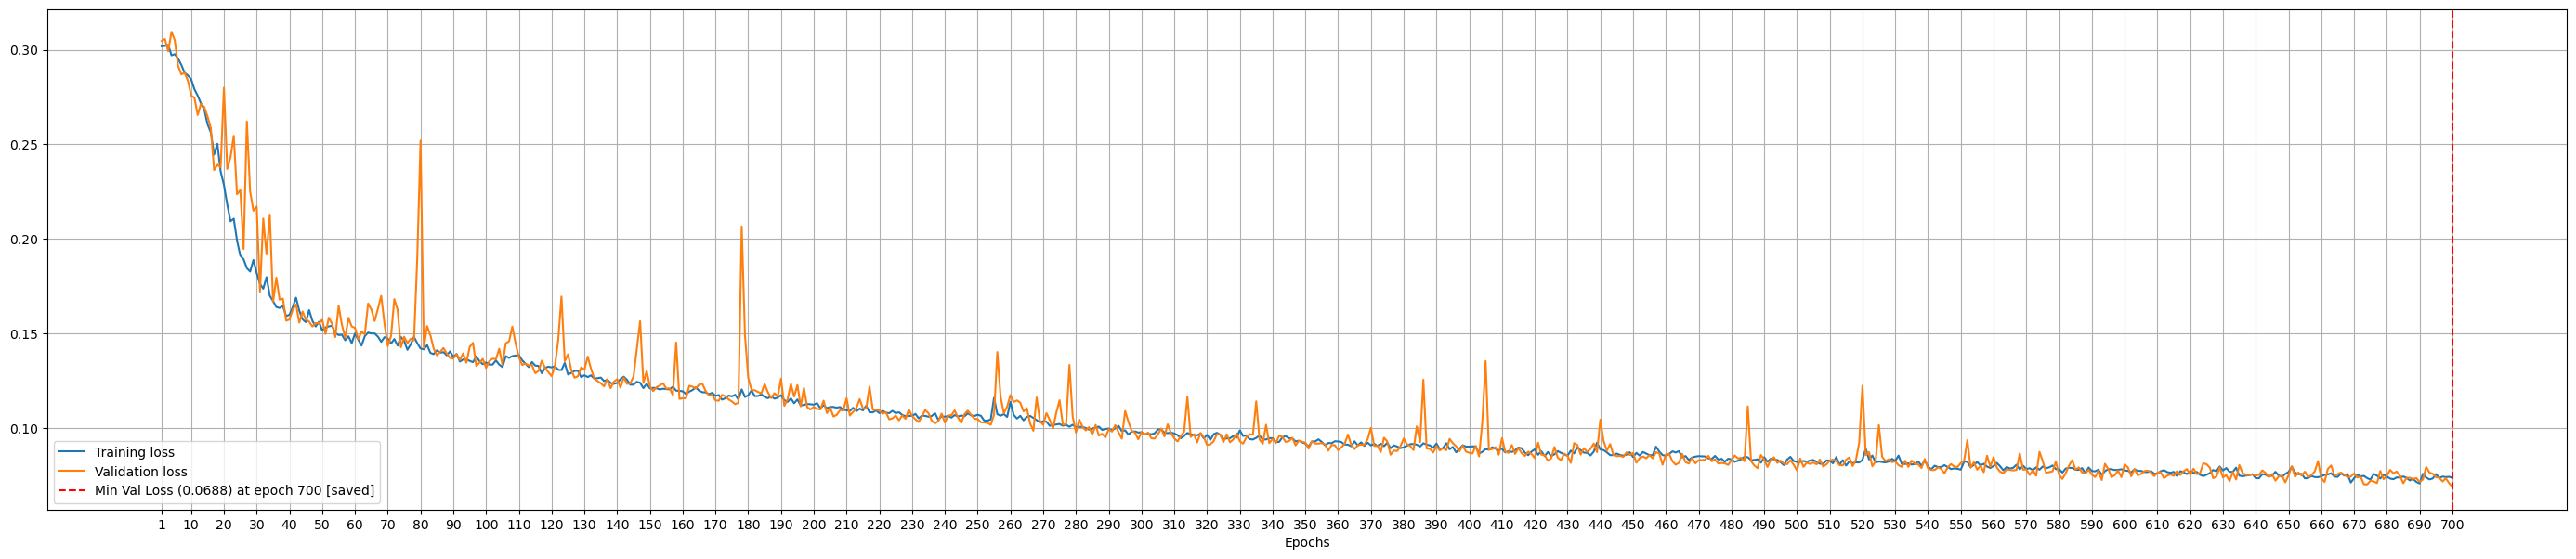

In [17]:
epochs_trained = len(history['train_loss'])
fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1, epochs_trained+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1, epochs_trained+1), history['val_loss'], label='Validation loss')

min_val_loss = min(history['val_loss'])
min_val_loss_epoch = history['val_loss'].index(min_val_loss) +1
plt.axvline(x=min_val_loss_epoch, color='red', linestyle='--', label=f'Min Val Loss ({min_val_loss:.4f}) at epoch {min_val_loss_epoch} [saved]')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)
#fig.autofmt_xdate()

plt.xlabel("Epochs")
plt.grid(True)
plt.legend()
plt.show()

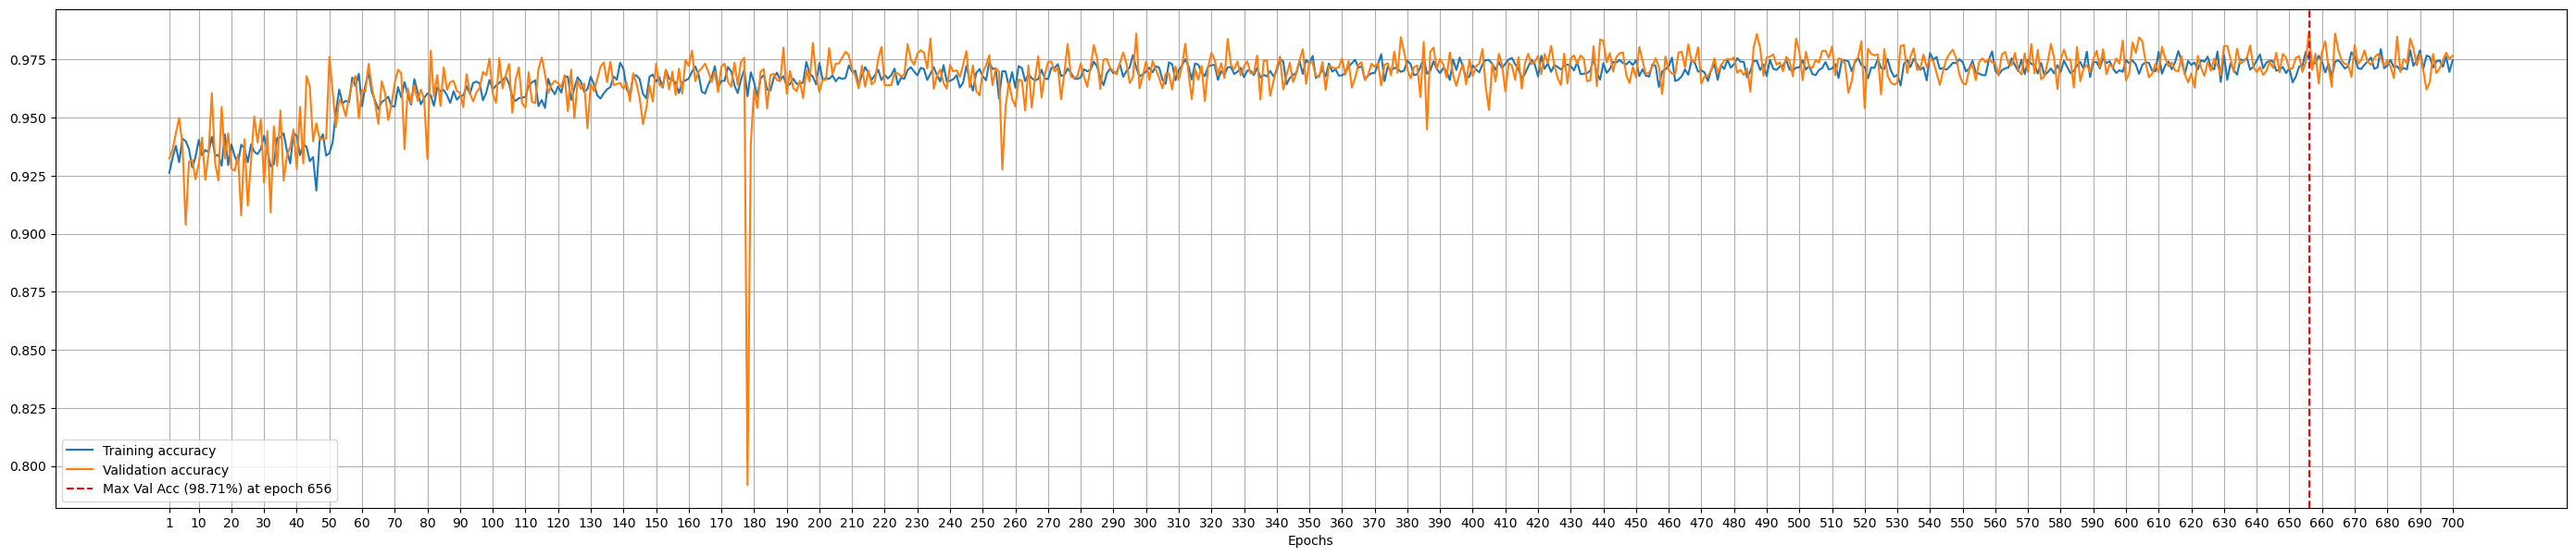

In [18]:
# from tensor to numpy
train_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['train_accuracy']]
val_accuracy_cpu = [acc.cpu().numpy()/100 for acc in history['val_accuracy']]
#print(train_accuracy_cpu)

fig = plt.figure(figsize=(max(10, 0.05 * epochs_trained), 7))
plt.plot(np.arange(1,epochs_trained+1), train_accuracy_cpu, label='Training accuracy')
plt.plot(np.arange(1,epochs_trained+1), val_accuracy_cpu, label='Validation accuracy')

max_val_acc = max(history['val_accuracy'])
max_val_acc_epoch = history['val_accuracy'].index(max_val_acc) +1
plt.axvline(x=max_val_acc_epoch, color='red', linestyle='--', label=f'Max Val Acc ({max_val_acc:.2f}%) at epoch {max_val_acc_epoch}')

interval=10
ticks = [1] + list(range(interval, epochs_trained + 1, interval))   #start in 1, go 1, 10, 20, 30...
plt.xticks(ticks)

#fig.autofmt_xdate()
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [19]:
# create model and load saved state 
# #model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
# load_model_path = './trained_models/20250126_214831_UNet_0.06924
# model.load_state_dict(torch.load(load_model_path))
model.to(device)
model.eval()     # !!! set the dropout and batch normalization layers to evaluation mode

ViGUNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128

In [20]:
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),  # evaluation at native resolution
    # v2.RandomRotation(degrees=(-180, 180)),
    # v2.RandomHorizontalFlip(),
    # v2.RandomVerticalFlip(),
    # v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.)),
    # v2.GaussianNoise(),
    # v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 1)),
    #transforms.ToTensor(),    # already tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# load test images
test_img_dir = './data/CHASE/test/images'
test_gt_dir = './data/CHASE/test/2nd_manual'

test_dataset = Dataset(test_img_dir, test_gt_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [21]:
#check test image
for img, gt, img_name in test_loader:
    print(f"Shape of image: {img.shape}")
    print(f"Shape of GT: {gt.shape}")
    print(f"Name of image: {img_name[0]}") 
    break  # just one

Shape of image: torch.Size([1, 3, 512, 512])
Shape of GT: torch.Size([1, 1, 512, 512])
Name of image: 01_test.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


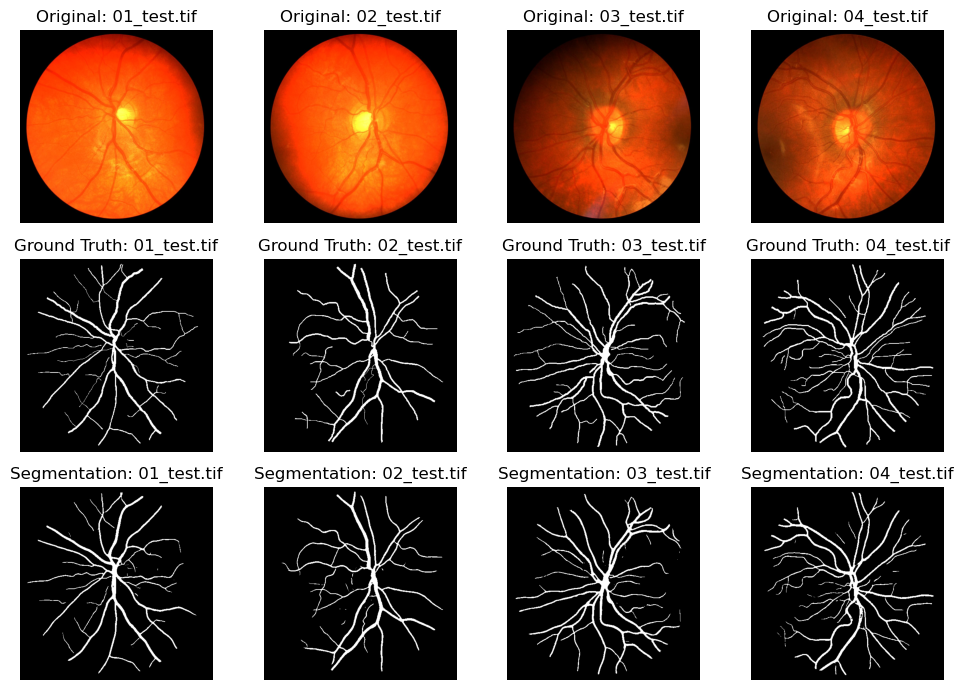

In [22]:
model.eval()   # done before, but just in case...

num_images = 4  # number of images to show
fig, axes = plt.subplots(3, num_images, figsize=(10, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")
        
        # test images ground truth segmentations
        axes[1, i].imshow(gt_img, cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Ground Truth: {image_name[0]}")

        # test images predicted segmentations
        axes[2, i].imshow(output_img, cmap='gray')  # grayscale
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

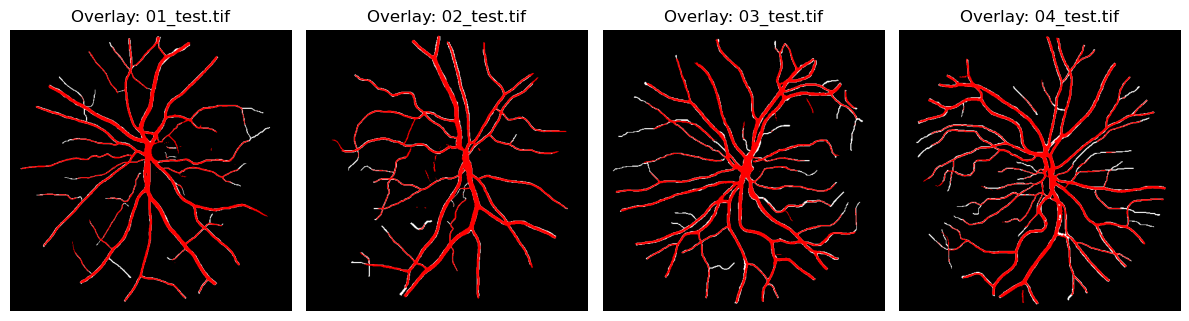

In [23]:
model.eval()   # done before, but just in case...

num_images = 4   # number of images to show
fig, axes = plt.subplots(1, num_images, figsize=(12, 8))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to CUDA
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # binarize prediction

        # convert prediction to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension
        gt_img = gt.squeeze().cpu().numpy()  # gt as image

        # Mostrar ground truth como fondo en escala de grises
        axes[i].imshow(gt_img, cmap='gray')  # Fondo: ground truth
        
        # Crear imagen RGBA para superponer
        overlay = np.zeros((*output_img.shape, 4))  # Crear un mapa RGBA
        overlay[..., 0] = 1  # Canal rojo
        overlay[..., 3] = output_img  # Canal alfa (0 para transparente, 1 para opaco)
        
        axes[i].imshow(overlay)  # Superposición en RGBA
        
        axes[i].axis('off')
        axes[i].set_title(f"Overlay: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

**ROC, AUC, Test Accuracy, Dice score, MCC, ccDice**


Dice score: 0.8208

MCC: 0.8083

ccDice score: 0.1695

Test Accuracy: 0.9755

F1 Score: 0.8204




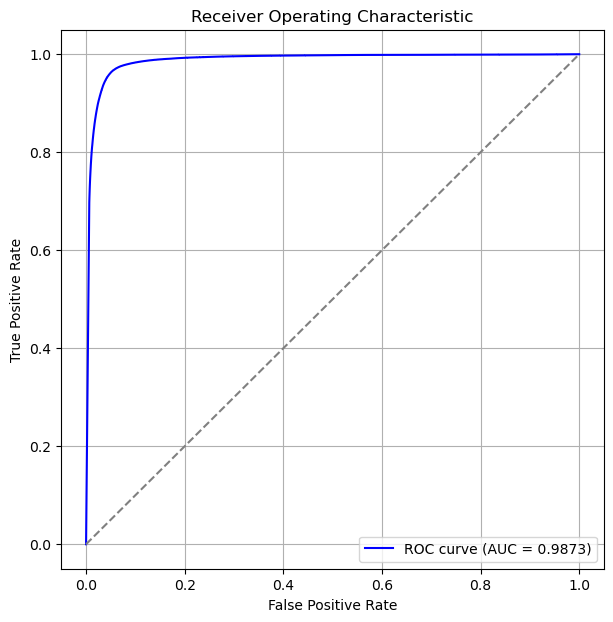

In [24]:
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from utils.dice_score import dice_score                     # custom function to calculate dice score
from utils.matthews_corr_coef import matthews_corr_coef     # custom function to calculate MCC
from utils.ccDice_score import ccDice                       # modified ccDice score (only binary labels)
from skimage.measure import label                           # necessary for ccDice

calculate_ccdice = True    # yes or no. Forced to use CPU: it takes long to compute (5 minutes just 8 images)

all_labels = []       # to store ground truth values for each pixel of each image
all_preds = []        # to store predicted values for each pixel of each image

dice_score_batches = []       # to store Dice score of each batch
mcc_batches = []              # to store MCC of each batch
if calculate_ccdice==True:
    ccdice_score_batches = []     # to store ccDice score of each batch

with torch.no_grad():  # no gradients needed
    for inputs, ground_truth, _ in test_loader:        # for each batch in test loader
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        outputs = model(inputs)     # predict

        all_labels.append(ground_truth.cpu().numpy())       # real labels for each pixel (0 or 1) 
        all_preds.append(outputs.cpu().numpy())             # probabilities to belong to class 1, given by model
        
        dice = dice_score(outputs, ground_truth, threshold=0.5)
        dice_score_batches.append(dice.item())
        
        mcc = matthews_corr_coef(outputs, ground_truth, threshold=0.5)
        mcc_batches.append(mcc)

        if calculate_ccdice==True:
            y_pred_label, cc_pred = label(((outputs > 0.5).float()).cpu().numpy().squeeze(0), return_num=True)
            y_true_label, cc_true = label(ground_truth.cpu().numpy().squeeze(0), return_num=True)
            ccdice = ccDice(y_pred_label, cc_pred, y_true_label, cc_true, alpha=0.1)    # alpha is level of exigency to join 2 cc (low is permissive, 1.0 is max exigency)
            ccdice_score_batches.append(ccdice)

# compute mean dice score and print
mean_dice_score = torch.tensor(dice_score_batches).mean()
print(f"\nDice score: {mean_dice_score:.4f}")

# compute mean MCC and print
mean_mcc = torch.tensor(mcc_batches).mean()
print(f"\nMCC: {mean_mcc:.4f}")

# compute mean ccDice score and print
if calculate_ccdice==True:
    mean_ccdice_score = torch.tensor(ccdice_score_batches).mean()
    print(f"\nccDice score: {mean_ccdice_score:.4f}")

# list to numpy array
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# compute mean test accuracy and print
accuracy_sklearn = accuracy_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nTest Accuracy: {accuracy_sklearn:.4f}")

# compute mean F1 score accuracy and print
f1_sklearn = f1_score(list(map(bool,all_labels.flatten())), (all_preds.flatten() > 0.5))
print(f"\nF1 Score: {f1_sklearn:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(list(map(bool,all_labels.flatten())), all_preds.flatten())     # force labels to binary list (if not, error when transform.resize)

# AUC
roc_auc = auc(fpr, tpr)

# plot ROC
print("\n")
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

trained_models\20250205_182055_ViGUNet_0.05962

In [25]:
# just to visualize the model architecture

'''from torch.utils.tensorboard import SummaryWriter
import torchvision

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/UNet')

# get some random training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)

print(images.shape)
images = images.to(device)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

#img_grid = img_grid.unsqueeze(0) 

# write to tensorboard
writer.add_image('train_img', img_grid)

writer.add_graph(model, images)
writer.close()

# write in terminal --->   tensorboard --logdir=runs/Unet'''

'from torch.utils.tensorboard import SummaryWriter\nimport torchvision\n\n# default `log_dir` is "runs" - we\'ll be more specific here\nwriter = SummaryWriter(\'runs/UNet\')\n\n# get some random training images\ndataiter = iter(train_loader)\nimages, labels, _ = next(dataiter)\n\nprint(images.shape)\nimages = images.to(device)\n\n# create grid of images\nimg_grid = torchvision.utils.make_grid(images)\n\n#img_grid = img_grid.unsqueeze(0) \n\n# write to tensorboard\nwriter.add_image(\'train_img\', img_grid)\n\nwriter.add_graph(model, images)\nwriter.close()\n\n# write in terminal --->   tensorboard --logdir=runs/Unet'